# Cosine Similarity Parallel

## Same as `Cosine-Similarity-Restarts` notebook, except I refactored the slot initialization code to be in ||

**Key idea:** The k-means algorithm often has some "restarts" encoded so that you can restart it several times (default 10 in scikit learn), and then choose the best result of the clustering algorithm.

In the `Cosine-similarity` notebook, I discovered that there was quite a bit of variance in the cosine similarity, even with keeping the (1) Same test batch size and (2) same model weights.

So my curiosity question is... if I keep the same setup, but just increase the number of query vectors that I sample, will I come to a better minimum?

**Key idea:** Choose the best samples based on the orthogonality of the query vectors. This ensures the queries focus on different parts of the input image :) 

In [2]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import json, yaml, os
os.sys.path.append('code')

from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from model import SoftPositionalEmbed, build_grid
from torch.nn import init
from train import train

%load_ext autoreload
%autoreload 2

In [3]:
device = 'cuda:0'

In [4]:
with open('code/configs/learn-init-warm2.yaml') as f:
    cd = yaml.safe_load(f)

hps = cd['hps']
del hps['softmax_T']
hps['device'] = device

hps

{'hidden_dim': 16,
 'k_slots': 3,
 'query_dim': 128,
 'learn_init': True,
 'device': 'cuda:0'}

In [4]:
from itertools import combinations

def cosineSimilarityParallel(att):
    '''
    Inputs:
     - att: tensor shape (bs, n_restarts, k_slots, pixel_dim)
    '''
    k_slots = att.shape[2]
    cs =  torch.cat([torch.nn.CosineSimilarity(dim=-1)(att[:,:,i],att[:,:,j])[None,:] 
                               for i,j in combinations(range(k_slots),2)], axis=0)
    return cs.sum(axis=0)    

In [5]:
class SlotAttentionParallel(torch.nn.Module):
    def __init__(self, 
                 resolution=(32,32),
                 k_slots=3, 
                 num_conv_layers=3,
                 hidden_dim=32, 
                 final_cnn_relu=False,
                 learn_init=False,
                 query_dim=32, 
                 n_iter=2,
                 pixel_mult=1,
                 pos_inpts=False,
                 device='cpu',
                 n_retarts=1
                 ):
        '''
        Slot attention encoder block with positional embedding

        Inputs:
        - resolution 
        - k_slots (default 3): number of slots (note, can vary between training and test time)
        - num_conv_layers: # of convolutional layers to apply (google paper has 4)
        - hidden_dim (default 32): The hidden dimension for the CNN (currently single layer w/ no non-linearities)
        - final_cnn_relu: Whether to apply the final cnn relu for these experiments (use true to mimic google repo)
        - query_dim (default 32): The latent space dimension that the slots and the queries get computed in
        - device (str): Which device to put the model on.
            Options: cpu (default), mps, cuda:{i}
            Also used when drawing random samples for the query points 
            and the grid generation for the positional encoding
        '''
        super().__init__()

        self.k_slots = k_slots
        self.hidden_dim = hidden_dim
        self.query_dim = query_dim
        self.n_iter = n_iter
        self.n_retarts = n_retarts
        
        self.resolution = resolution

        self.device=device
        
        self.softmax_T = 1/np.sqrt(query_dim)

        self.dataN = torch.nn.LayerNorm(self.hidden_dim)
        self.queryN = torch.nn.LayerNorm(self.query_dim)
        
        self.toK = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.toV = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.gru = torch.nn.GRUCell(self.query_dim, self.query_dim)

        input_dim = 5 if pos_inpts else 1 # whether or not to include the pixels w/ the input
        
        kwargs = { 'out_channels': hidden_dim,'kernel_size': 5, 'padding':2 }

        cnn_layers = [torch.nn.Conv2d(input_dim,**kwargs)]
        for i in range(num_conv_layers-1):
            cnn_layers += [torch.nn.ReLU(), torch.nn.Conv2d(hidden_dim,**kwargs)] 
            
        if final_cnn_relu:
            '''
            22.08.2023 Silly mistake, I didn't include a ReLU() after the last CNN filter 
            for first exps. This `final_cnn_relu` flag is a hack for bkwds compatibility.
            '''
            cnn_layers.append(torch.nn.ReLU())

        self.CNN_encoder = torch.nn.Sequential(*cnn_layers)
          
        self.posEnc = SoftPositionalEmbed(hidden_dim, resolution,device, pixel_mult)
        
        if pos_inpts:
            self.process_data = lambda X: \
                torch.cat([X,
                torch.tile(self.posEnc.grid.permute(0,3,1,2), [X.shape[0],1,1,1])],dim=1)
        else:
            self.process_data = lambda X: X

        self.init_mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim,hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim,hidden_dim)
        )
        
        self.slots_mu = torch.nn.Parameter(torch.randn(1, 1, self.query_dim))
        self.slots_logsigma = torch.nn.Parameter(torch.zeros(1, 1, self.query_dim))
        init.xavier_uniform_(self.slots_logsigma)

    def init_slots(self,Nbatch):
        '''
        Slot init taken from
        https://github.com/lucidrains/slot-attention/blob/master/slot_attention/slot_attention.py
        '''
        
        mu = self.slots_mu.expand(Nbatch, self.k_slots, -1)
        sigma = self.slots_logsigma.exp().expand(Nbatch, self.k_slots, -1)

        # Note -- I can simplify this later, but for now I 
        # need to do the reshaping differently, otherwise I can't 
        # start from a warm start
        mu = torch.tile(mu[:,None],dims=(1,self.n_retarts,1,1))
        sigma = torch.tile(sigma[:,None],dims=(1,self.n_retarts,1,1))
            
        return mu + sigma * torch.randn(mu.shape).to(self.device)
    
    def encoder(self,data):

        # If pos_inpts was passed at initialization, concatenate the grid
        encoded_data = self.process_data(data)

        # Apply the CNN encoder
        encoded_data = self.CNN_encoder(encoded_data)
        
        # Put the channel dim at the end
        encoded_data = torch.permute(encoded_data,(0,2,3,1)) 
                 
        # Add the positional embeddings
        encoded_data = self.posEnc(encoded_data)
        
        # Flatten the pixel dims and apply the data normalization + MLP
        encoded_data = torch.flatten(encoded_data,1,2)
        encoded_data = self.dataN(encoded_data)
        encoded_data = self.init_mlp(encoded_data)
        
        return encoded_data
        
    def attention_and_weights(self,queries,encoded_data):
        
        keys = self.toK(encoded_data)
        logits = torch.einsum('b...se,bde->b...sd',queries,keys) * self.softmax_T
        
        att = torch.nn.functional.softmax(logits, dim = 2) 

        div = torch.sum(att, dim = -1, keepdims = True)
        wts = att/div + 1e-8
        return att,wts

    def iterate(self, queries, encoded_data):
        
        # queries: (bs, k_slots, query_dim)
        # att, wts: (bs, k_slots, img_dim)
        att,wts = self.attention_and_weights(self.queryN(queries),encoded_data)   
        
        vals = self.toV(encoded_data) # bs, img_dim, query_dim
        updates = torch.einsum('b...sd,bde->b...se',wts,vals) # bs, n_restarts n_slots, query_dim
        
        updates = self.gru(
            updates.reshape(-1,self.query_dim),
            queries.reshape(-1,self.query_dim))

        return updates.reshape(queries.shape)
        
    
    def forward(self, data):
        
        # Get the encoded view of the image
        encoded_data = self.encoder(data)
        
        Nbatch = encoded_data.shape[0]
        queries = self.init_slots(Nbatch) # Shape (Nbatch, k_slots, query_dim)
        
        for i in range(self.n_iter):
            queries = self.iterate(queries, encoded_data)    
            
        # Then with the _final_ query vector, calc what the attn + weights would be
        att, wts = self.attention_and_weights(self.queryN(queries),encoded_data)   
            
        cs = cosineSimilarityParallel(att)
        
        i_b = np.arange(Nbatch)
        i_s = torch.argmin(cs,dim=1)
            
        return queries[i_b,i_s], att[i_b,i_s], wts[i_b,i_s] 

In [6]:
hps['device'] = device

In [7]:
m = SlotAttentionParallel(n_retarts=10,**hps).to(device)

weightPath = 'code/models/learn-init-warm/m_44000.pt'
m.load_state_dict(torch.load(weightPath,map_location=device))


<All keys matched successfully>

In [8]:
torch.cuda.is_available()

True

In [19]:
cID = 'li-warm-parallel-10x'
modelDir = f'code/models/{cID}'
figDir = f'code/figures/{cID}'

# for d in [modelDir,figDir]:
#     os.mkdir(d)

In [20]:
opt = cd['opt']
opt['Ntrain'] = 500_000

kwargs = cd['data']

In [21]:
opt

{'lr': 0.000275, 'Ntrain': 500000, 'bs': 256}

Training model with 3 slots on 2rings
iter 5 , loss 0.020529501 , lr 2.749809391131423e-07


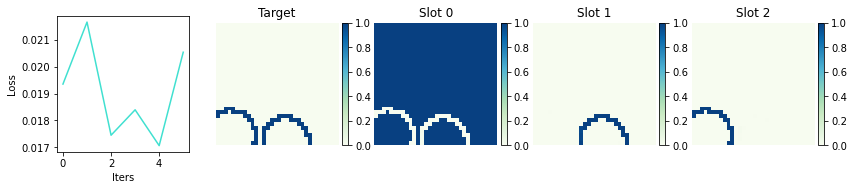

iter 10 , loss 0.02043837 , lr 5.499237590948773e-07


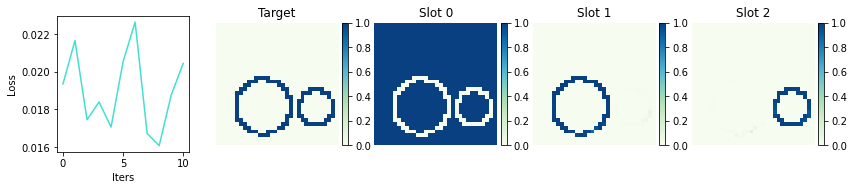

iter 15 , loss 0.020463604 , lr 8.248284639083933e-07


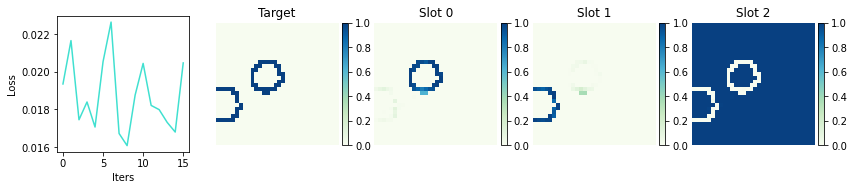

iter 20 , loss 0.01740431 , lr 1.0996950575165116e-06


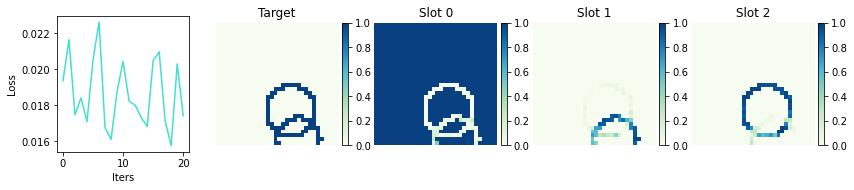

iter 25 , loss 0.02021224 , lr 1.374523543881688e-06


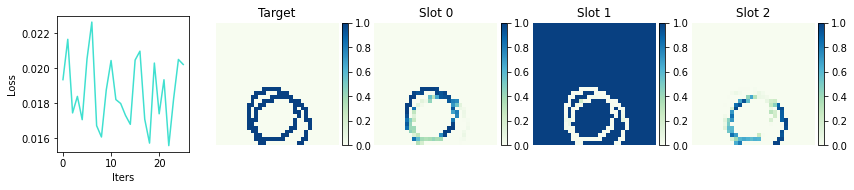

iter 30 , loss 0.021687333 , lr 1.6493139269660116e-06


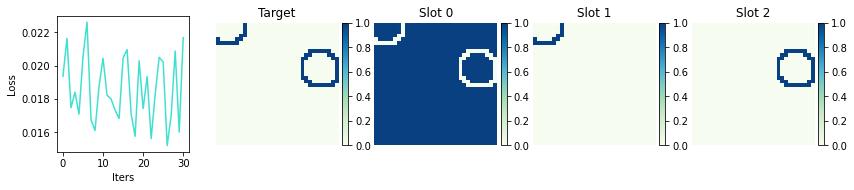

iter 35 , loss 0.017973807 , lr 1.924066210731205e-06


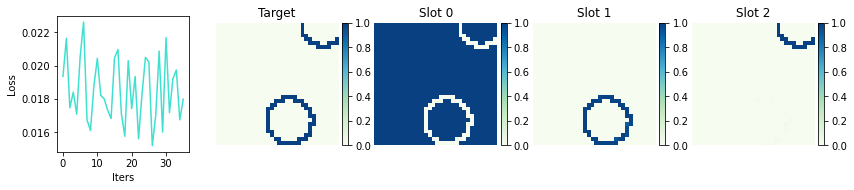

iter 40 , loss 0.020930383 , lr 2.1987803991386256e-06


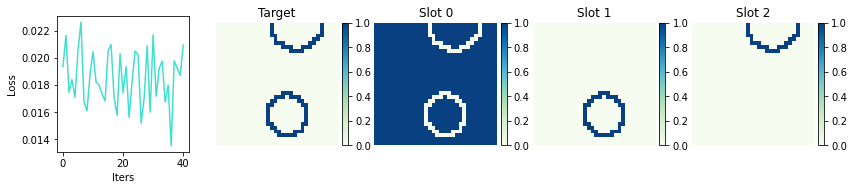

iter 45 , loss 0.019352939 , lr 2.4734564961492636e-06


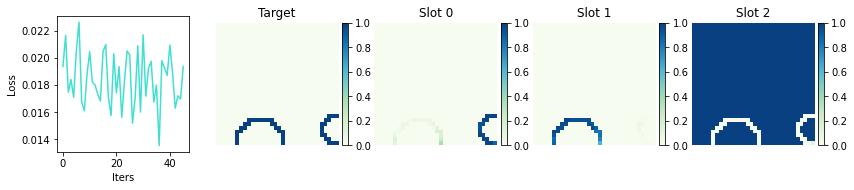

iter 50 , loss 0.0183418 , lr 2.748094505723744e-06


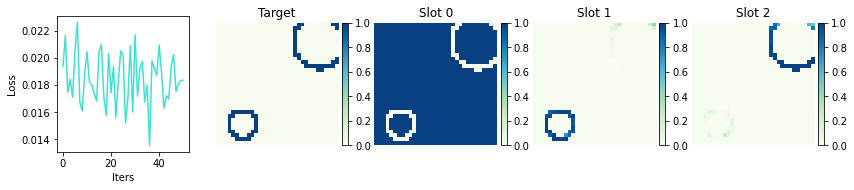

iter 55 , loss 0.016935915 , lr 3.022694431822327e-06


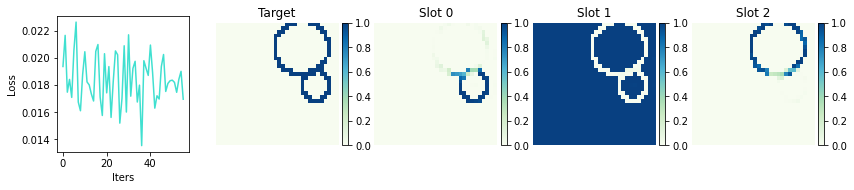

iter 60 , loss 0.018042255 , lr 3.297256278404903e-06


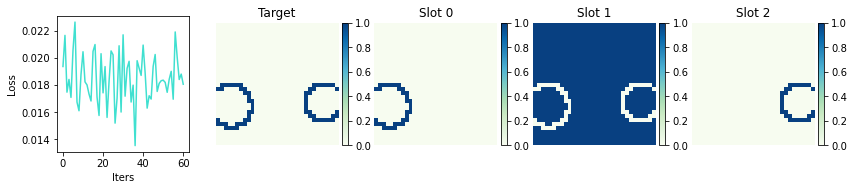

iter 65 , loss 0.020360468 , lr 3.571780049431e-06


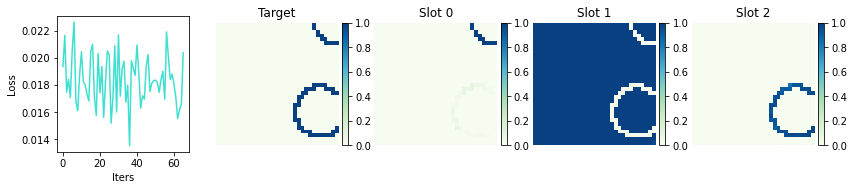

iter 70 , loss 0.02120629 , lr 3.846265748859779e-06


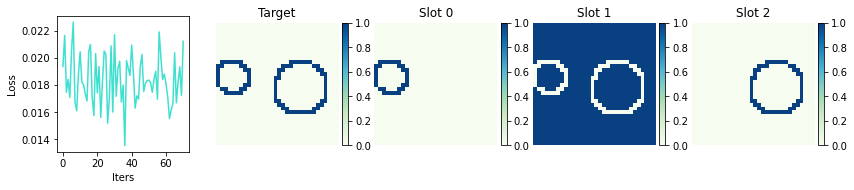

iter 75 , loss 0.01826017 , lr 4.120713380650033e-06


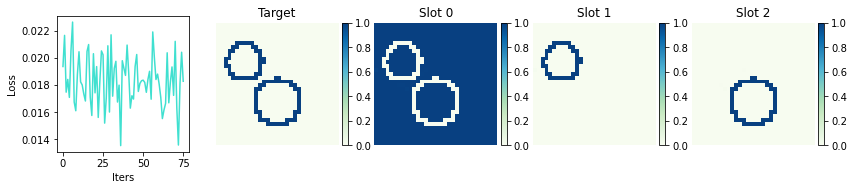

iter 80 , loss 0.018902494 , lr 4.395122948760193e-06


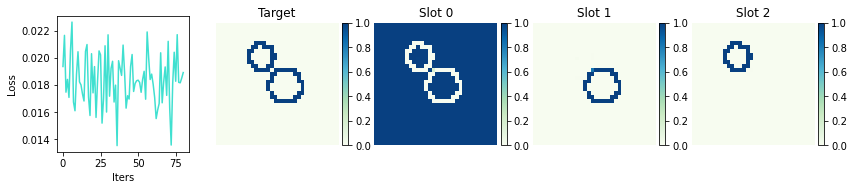

iter 85 , loss 0.014485918 , lr 4.669494457148321e-06


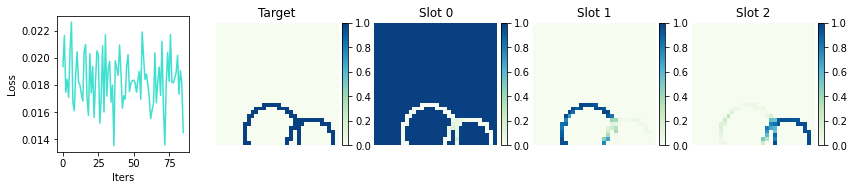

iter 90 , loss 0.018988553 , lr 4.943827909772114e-06


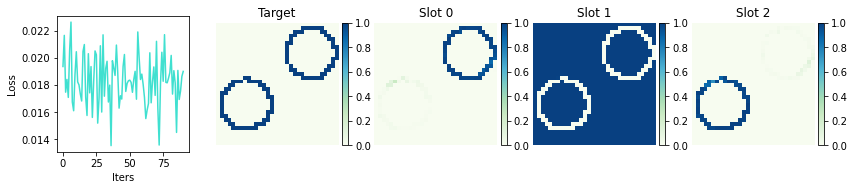

iter 95 , loss 0.019084007 , lr 5.218123310588906e-06


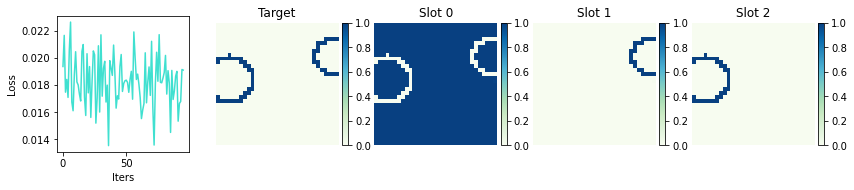

iter 100 , loss 0.01807004 , lr 5.4923806635556595e-06


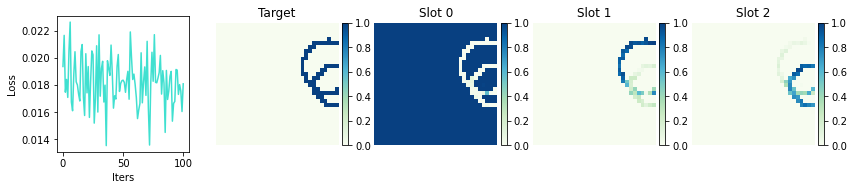

iter 105 , loss 0.01635196 , lr 5.7665999726289765e-06


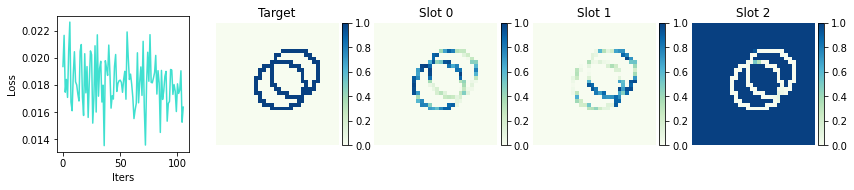

iter 110 , loss 0.016502846 , lr 6.04078124176509e-06


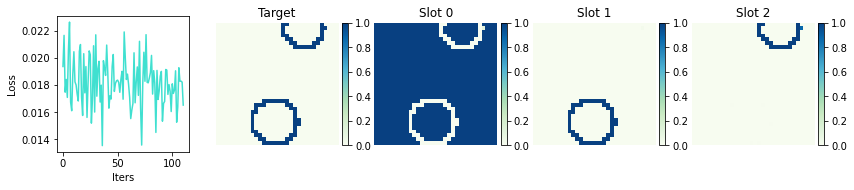

iter 115 , loss 0.0208885 , lr 6.314924474919869e-06


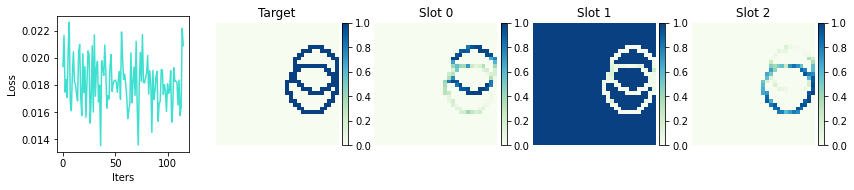

iter 120 , loss 0.018143939 , lr 6.58902967604882e-06


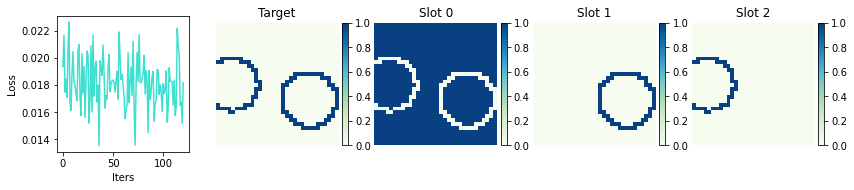

iter 125 , loss 0.01679546 , lr 6.863096849107075e-06


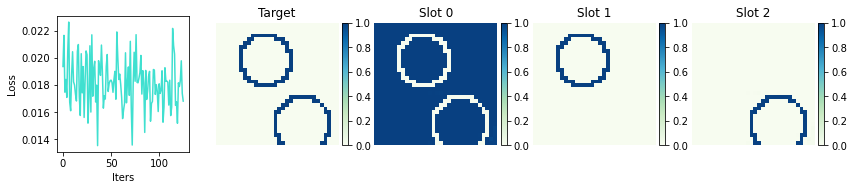

iter 130 , loss 0.014985554 , lr 7.137125998049406e-06


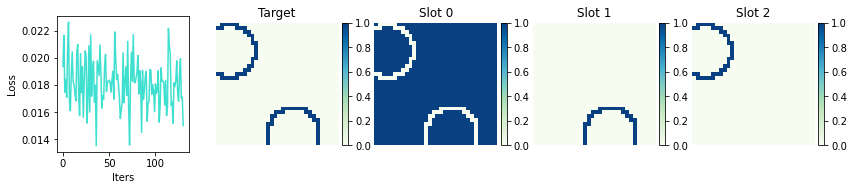

iter 135 , loss 0.017277637 , lr 7.411117126830226e-06


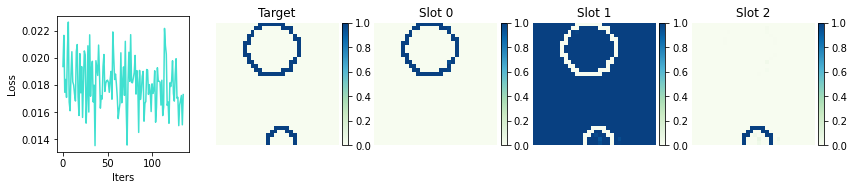

iter 140 , loss 0.019779768 , lr 7.68507023940357e-06


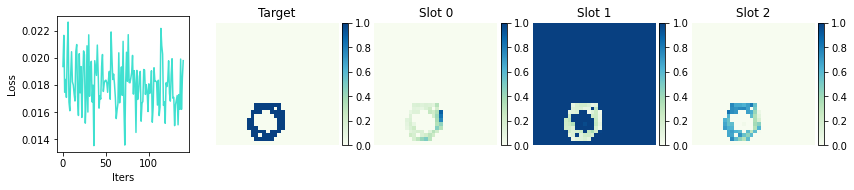

iter 145 , loss 0.016864171 , lr 7.958985339723113e-06


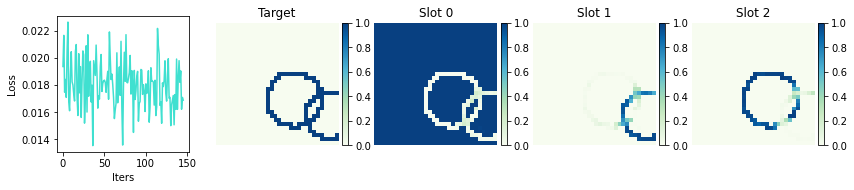

iter 150 , loss 0.018573567 , lr 8.232862431742168e-06


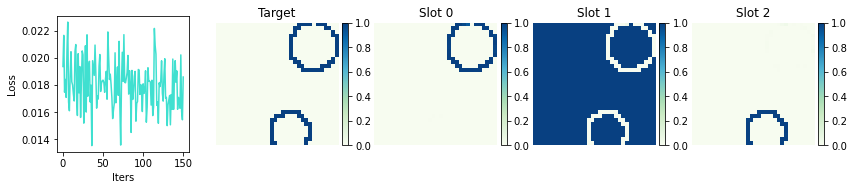

iter 155 , loss 0.017722882 , lr 8.506701519413679e-06


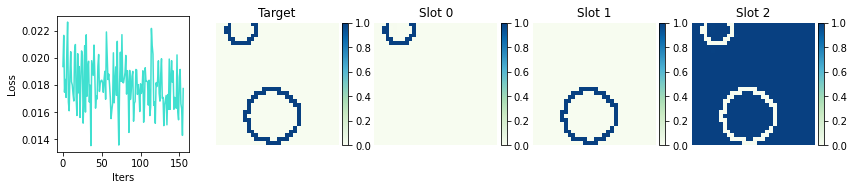

iter 160 , loss 0.016012844 , lr 8.780502606690224e-06


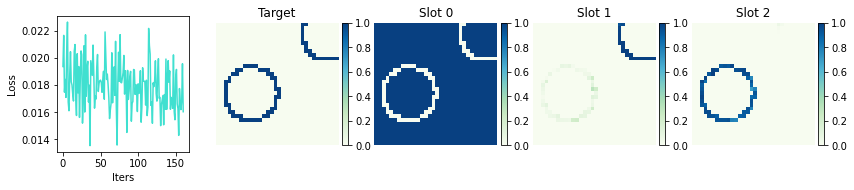

iter 165 , loss 0.01670117 , lr 9.054265697524015e-06


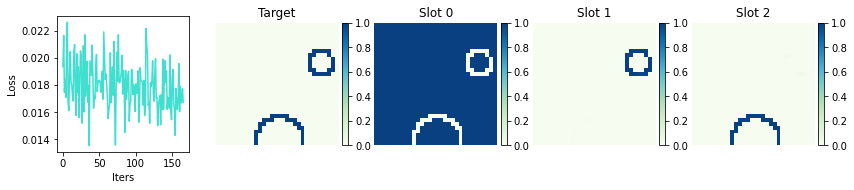

iter 170 , loss 0.013854912 , lr 9.327990795866906e-06


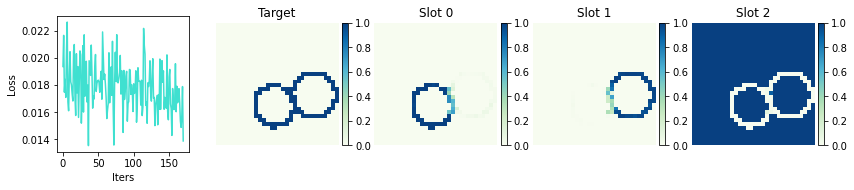

iter 175 , loss 0.014735664 , lr 9.601677905670375e-06


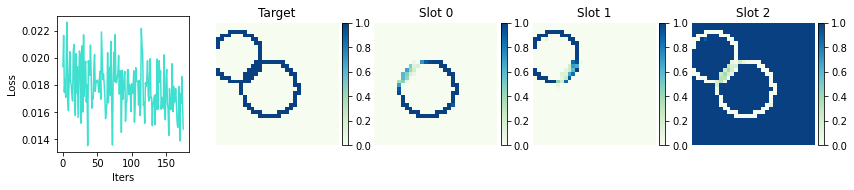

iter 180 , loss 0.01569734 , lr 9.87532703088554e-06


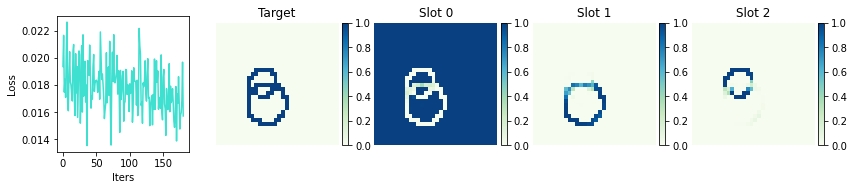

iter 185 , loss 0.015441878 , lr 1.0148938175463159e-05


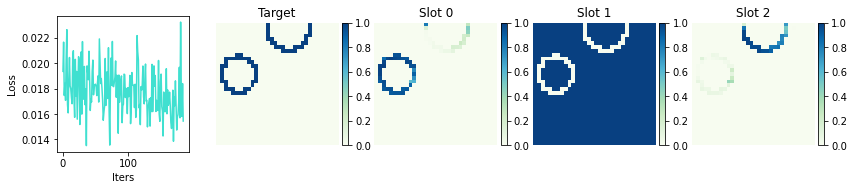

iter 190 , loss 0.018382672 , lr 1.0422511343353613e-05


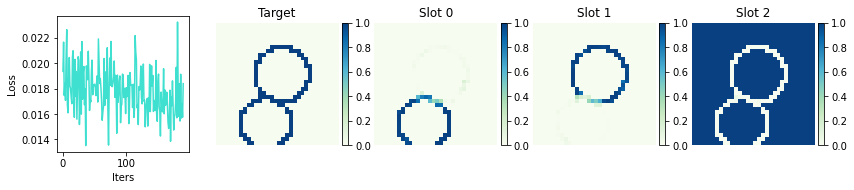

iter 195 , loss 0.020018442 , lr 1.069604653850693e-05


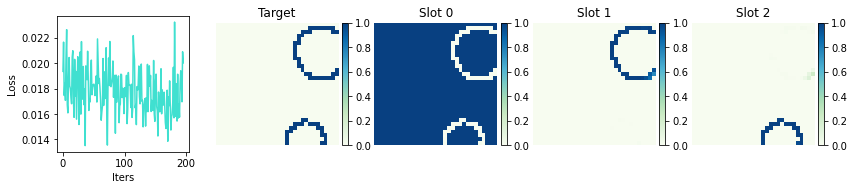

iter 200 , loss 0.021650609 , lr 1.0969543764872765e-05


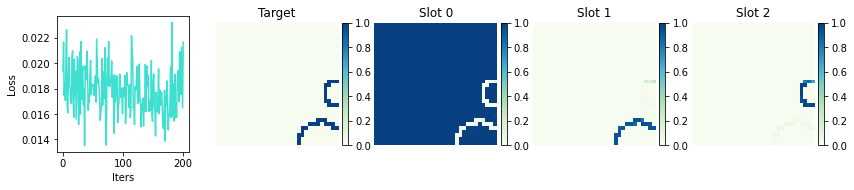

iter 205 , loss 0.018350987 , lr 1.124300302640041e-05


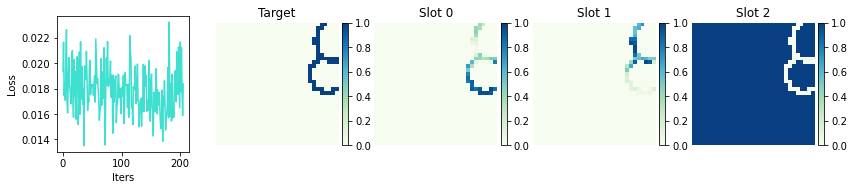

iter 210 , loss 0.016674273 , lr 1.1516424327038792e-05


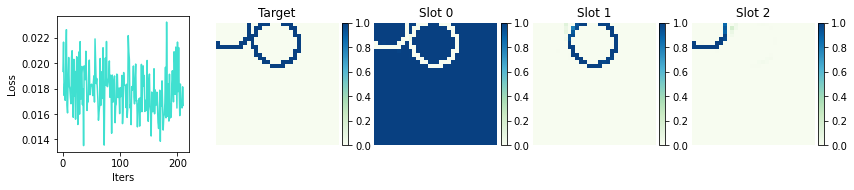

iter 215 , loss 0.016057085 , lr 1.1789807670736471e-05


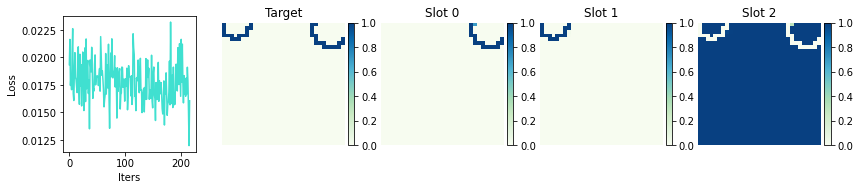

iter 220 , loss 0.015464905 , lr 1.2063153061441647e-05


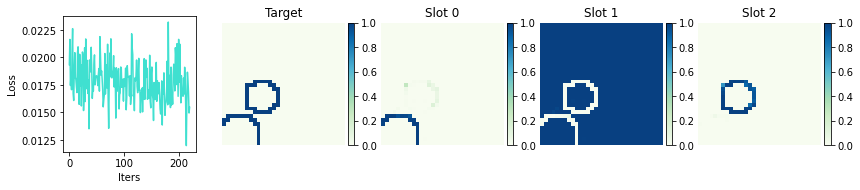

iter 225 , loss 0.017877024 , lr 1.233646050310215e-05


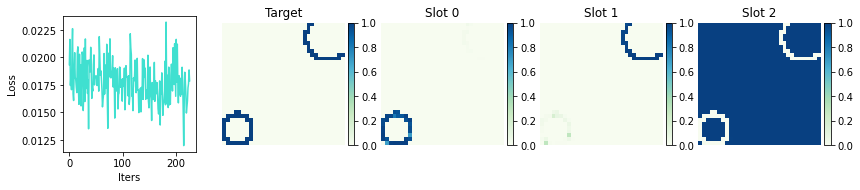

iter 230 , loss 0.016100066 , lr 1.260972999966545e-05


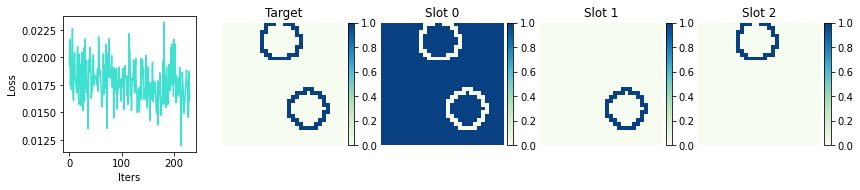

iter 235 , loss 0.017553378 , lr 1.288296155507865e-05


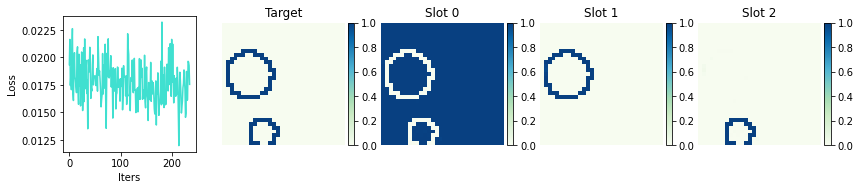

iter 240 , loss 0.018703612 , lr 1.3156155173288484e-05


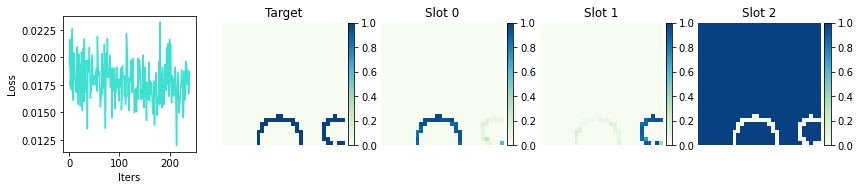

iter 245 , loss 0.014661255 , lr 1.3429310858241329e-05


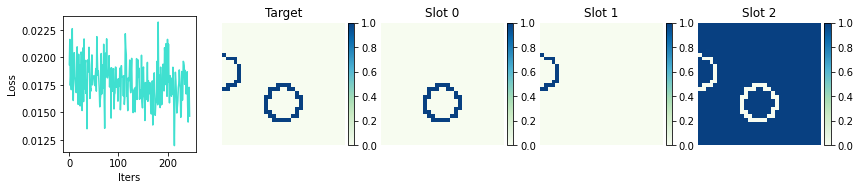

iter 250 , loss 0.019529182 , lr 1.3702428613883184e-05


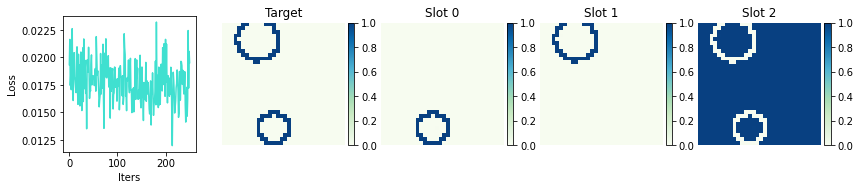

iter 255 , loss 0.014212277 , lr 1.3975508444159697e-05


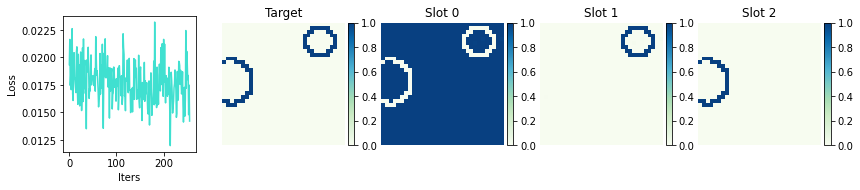

iter 260 , loss 0.016864307 , lr 1.4248550353016152e-05


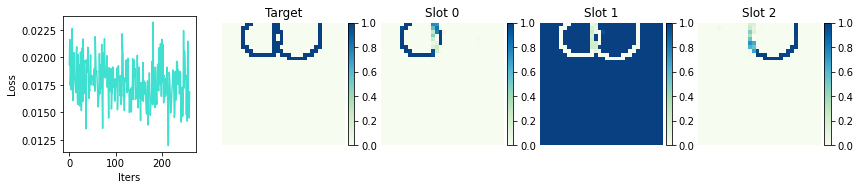

iter 265 , loss 0.016994001 , lr 1.4521554344397456e-05


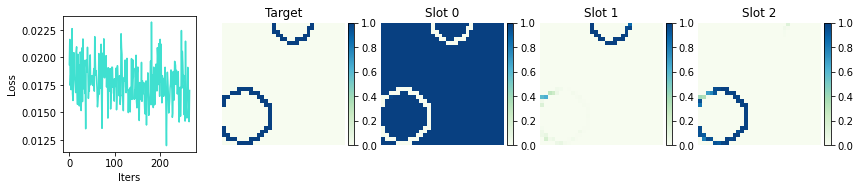

iter 270 , loss 0.017337551 , lr 1.479452042224816e-05


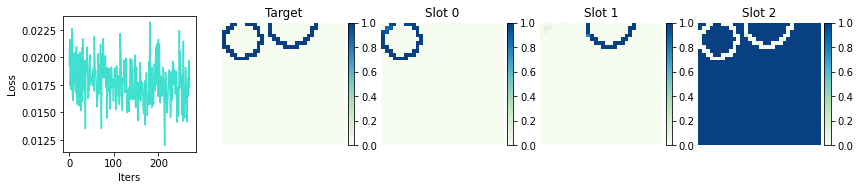

iter 275 , loss 0.019409092 , lr 1.5067448590512447e-05


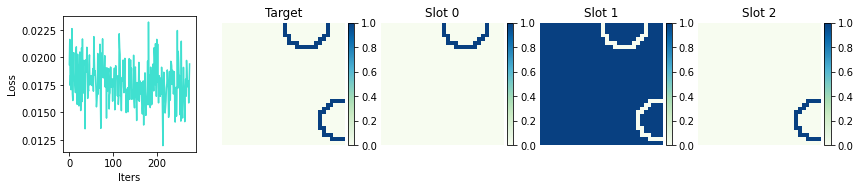

iter 280 , loss 0.0176467 , lr 1.534033885313414e-05


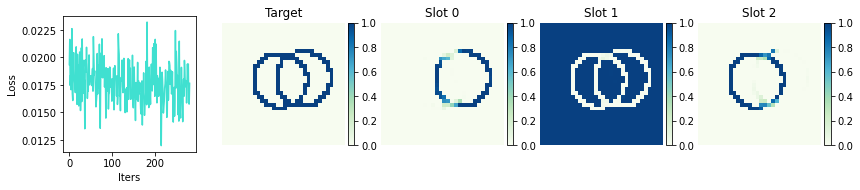

iter 285 , loss 0.01869087 , lr 1.5613191214056685e-05


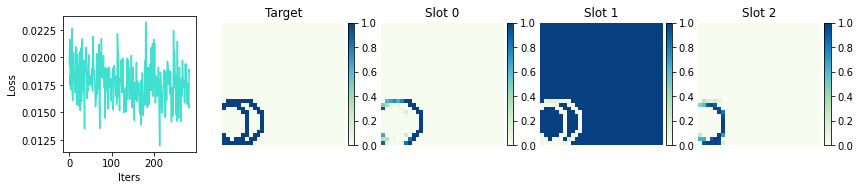

iter 290 , loss 0.01772343 , lr 1.588600567722318e-05


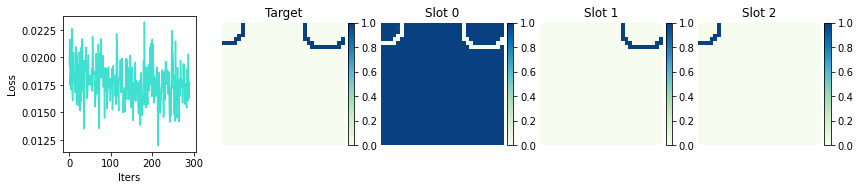

iter 295 , loss 0.016171813 , lr 1.6158782246576352e-05


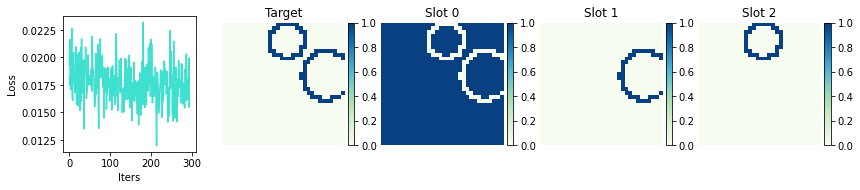

iter 300 , loss 0.017742414 , lr 1.6431520926058558e-05


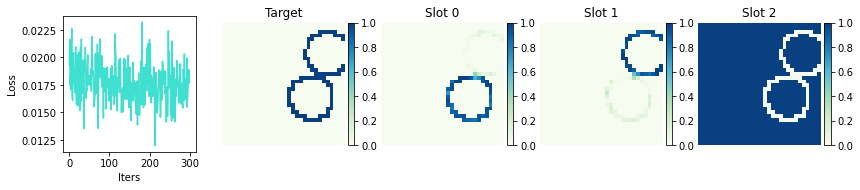

iter 305 , loss 0.017468333 , lr 1.67042217196118e-05


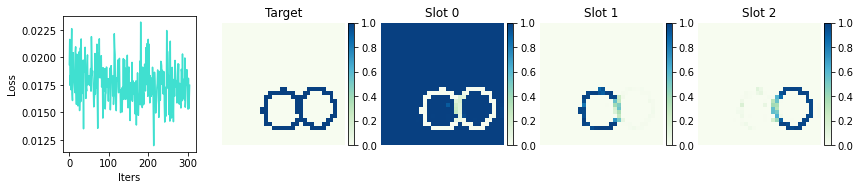

iter 310 , loss 0.015526978 , lr 1.6976884631177707e-05


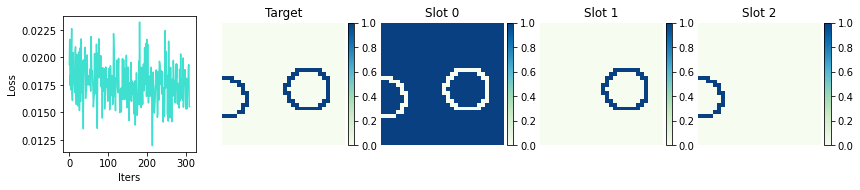

iter 315 , loss 0.0160237 , lr 1.7249509664697548e-05


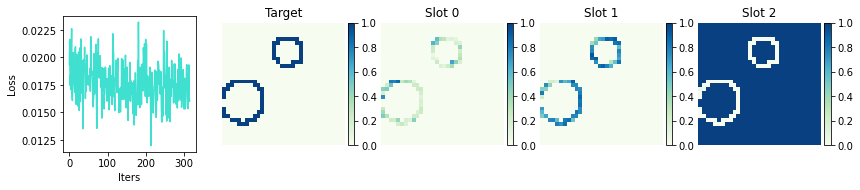

iter 320 , loss 0.013848199 , lr 1.7522096824112227e-05


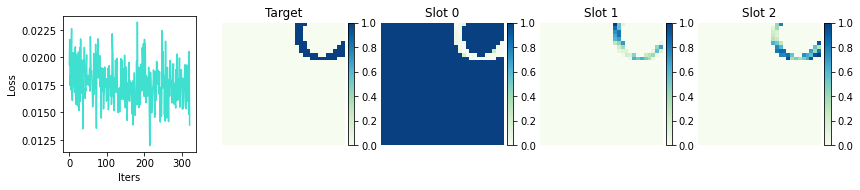

iter 325 , loss 0.016430132 , lr 1.779464611336228e-05


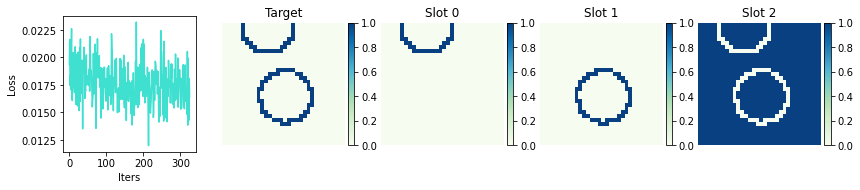

iter 330 , loss 0.016369412 , lr 1.8067157536387887e-05


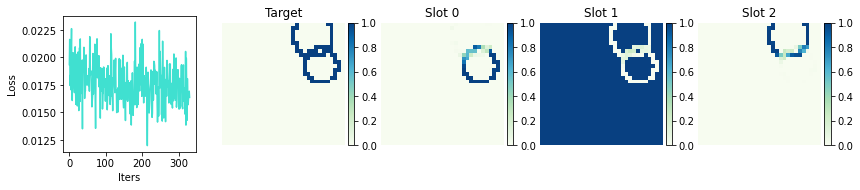

iter 335 , loss 0.017956095 , lr 1.833963109712886e-05


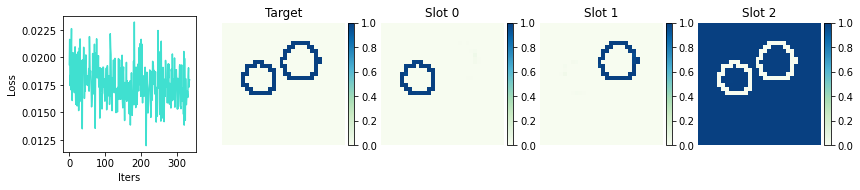

iter 340 , loss 0.01766869 , lr 1.8612066799524642e-05


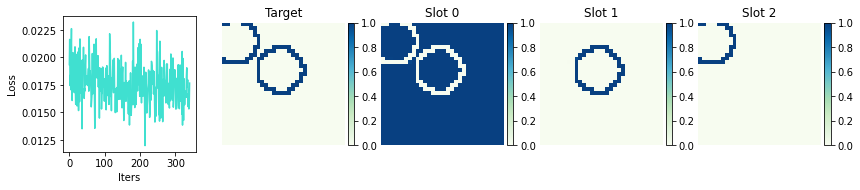

iter 345 , loss 0.016572032 , lr 1.8884464647514316e-05


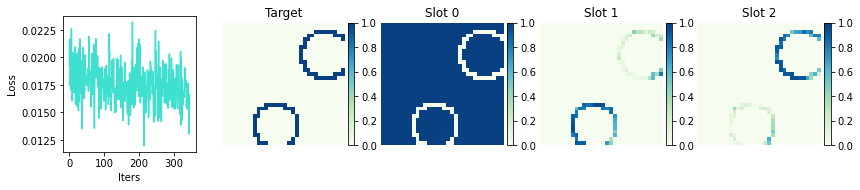

iter 350 , loss 0.01472313 , lr 1.91568246450366e-05


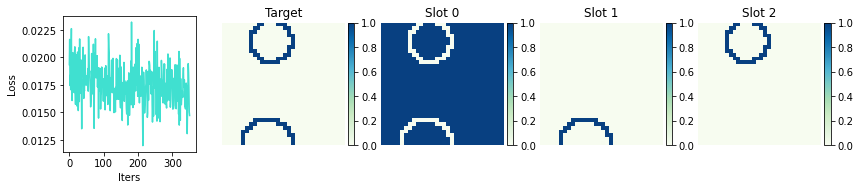

iter 355 , loss 0.017650366 , lr 1.9429146796029843e-05


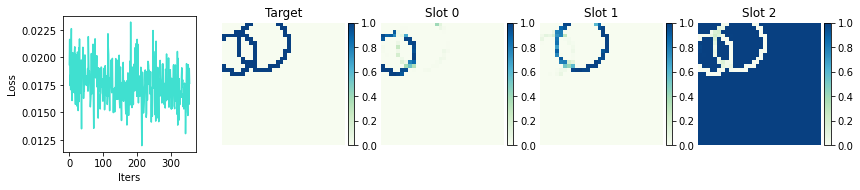

iter 360 , loss 0.016598057 , lr 1.9701431104432046e-05


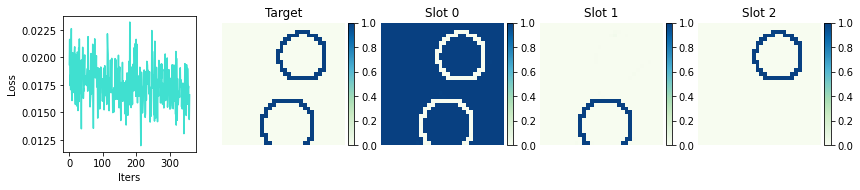

iter 365 , loss 0.01530507 , lr 1.997367757418083e-05


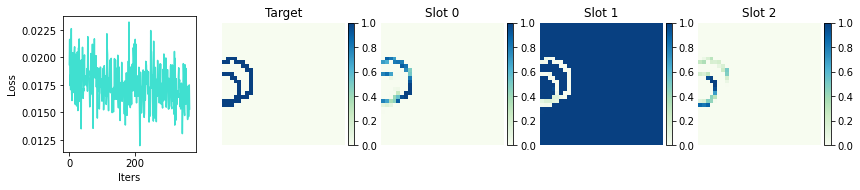

iter 370 , loss 0.020555254 , lr 2.0245886209213456e-05


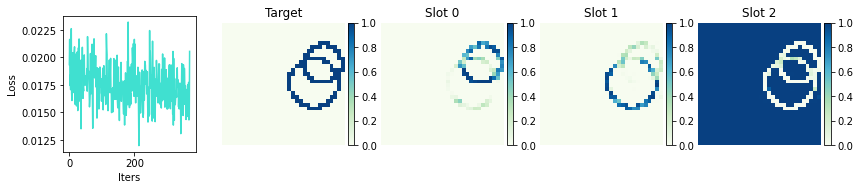

iter 375 , loss 0.017002787 , lr 2.0518057013466826e-05


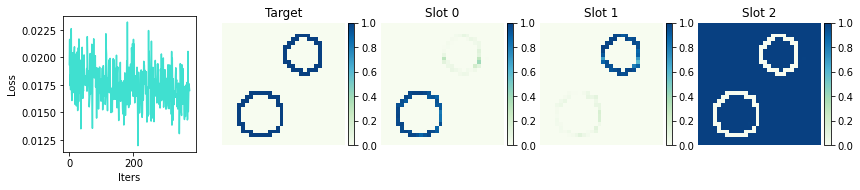

iter 380 , loss 0.019085605 , lr 2.0790189990877468e-05


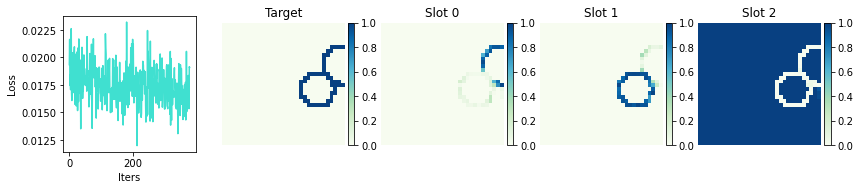

iter 385 , loss 0.019244023 , lr 2.1062285145381552e-05


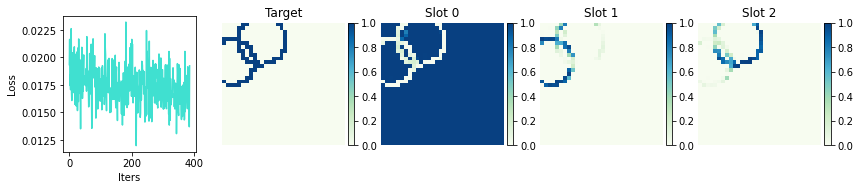

iter 390 , loss 0.01760516 , lr 2.133434248091489e-05


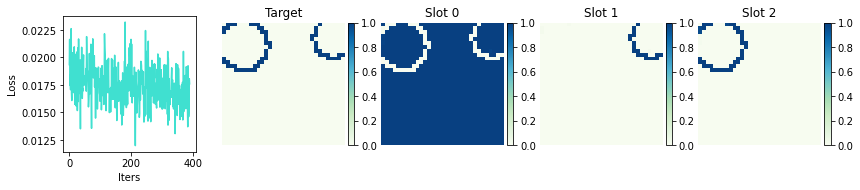

iter 395 , loss 0.014777513 , lr 2.1606362001412922e-05


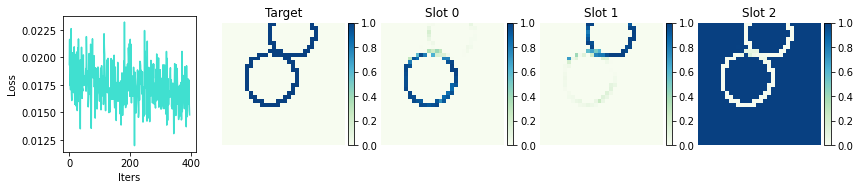

iter 400 , loss 0.016694251 , lr 2.1878343710810718e-05


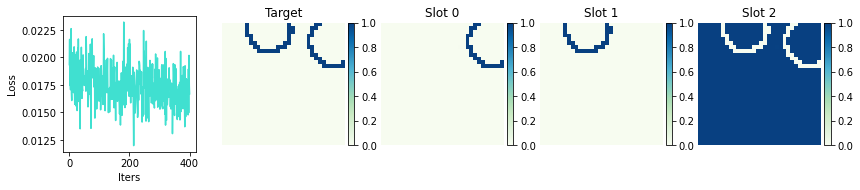

iter 405 , loss 0.015186469 , lr 2.2150287613043004e-05


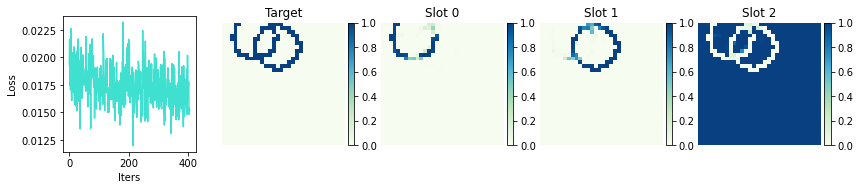

iter 410 , loss 0.02114129 , lr 2.2422193712044126e-05


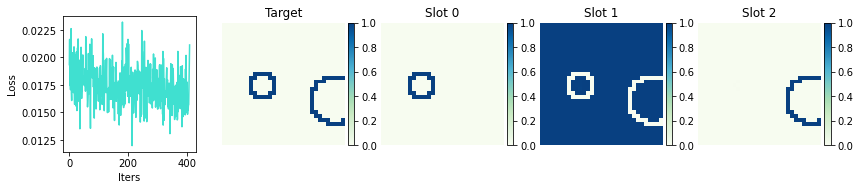

iter 415 , loss 0.013906663 , lr 2.269406201174807e-05


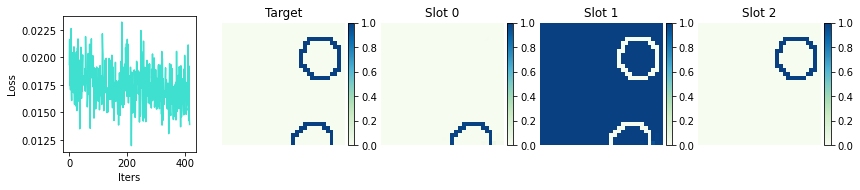

iter 420 , loss 0.016772823 , lr 2.296589251608846e-05


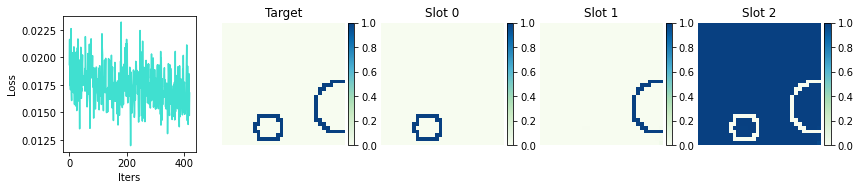

iter 425 , loss 0.015970122 , lr 2.3237685228998554e-05


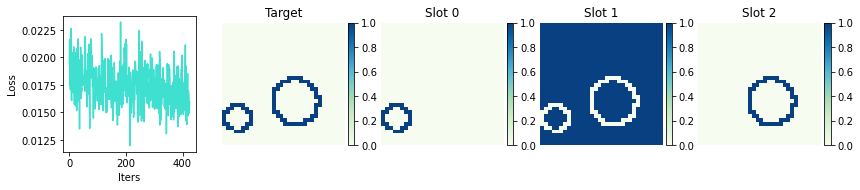

iter 430 , loss 0.0129503915 , lr 2.350944015441125e-05


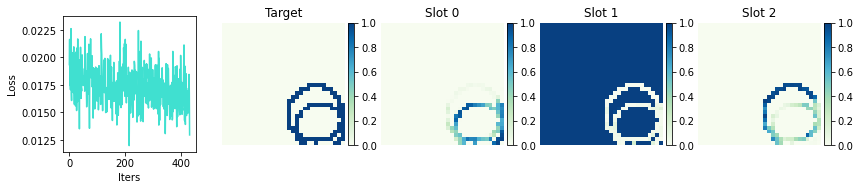

iter 435 , loss 0.01625799 , lr 2.378115729625908e-05


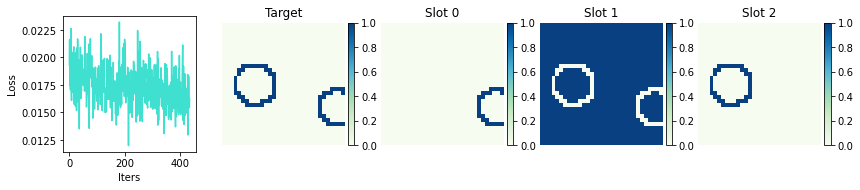

iter 440 , loss 0.017961707 , lr 2.405283665847421e-05


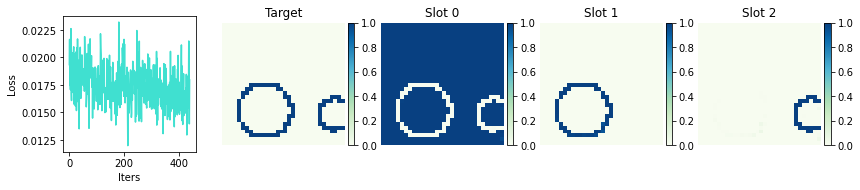

iter 445 , loss 0.017383054 , lr 2.4324478244988444e-05


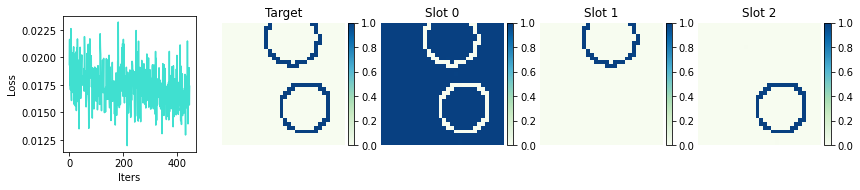

iter 450 , loss 0.01659162 , lr 2.459608205973323e-05


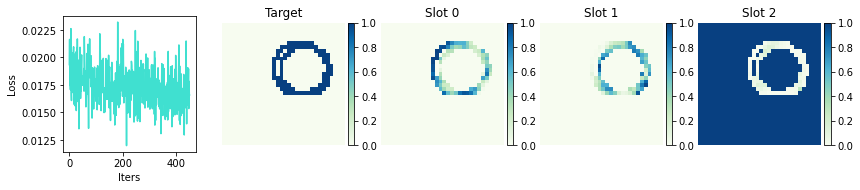

iter 455 , loss 0.0152067635 , lr 2.486764810663965e-05


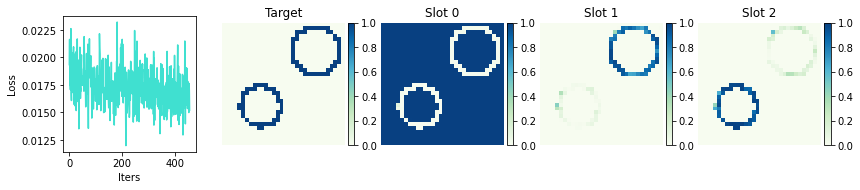

iter 460 , loss 0.017184034 , lr 2.51391763896384e-05


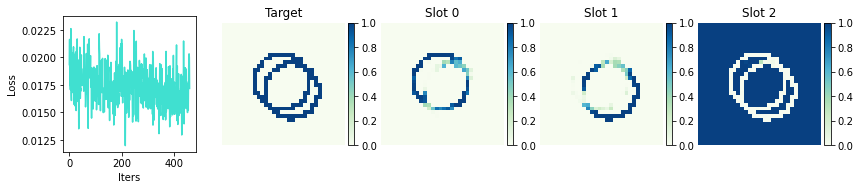

iter 465 , loss 0.016749583 , lr 2.5410666912659845e-05


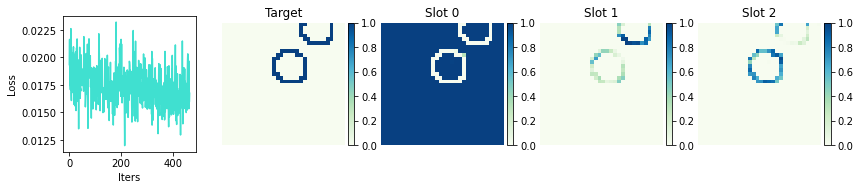

iter 470 , loss 0.01634394 , lr 2.568211967963397e-05


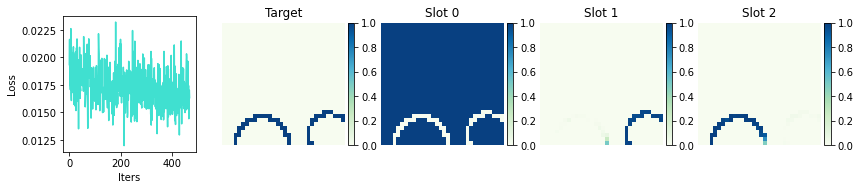

iter 475 , loss 0.01833535 , lr 2.5953534694490392e-05


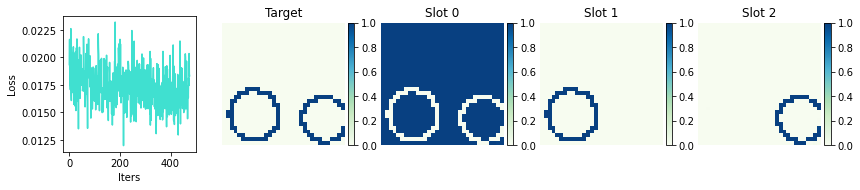

iter 480 , loss 0.014477128 , lr 2.622491196115839e-05


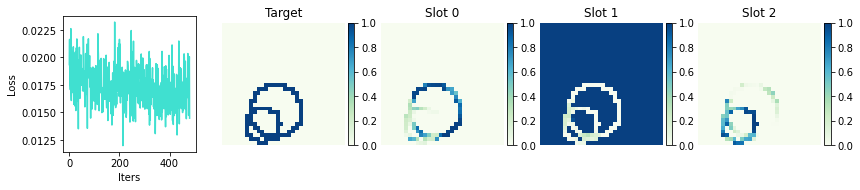

iter 485 , loss 0.018659398 , lr 2.649625148356684e-05


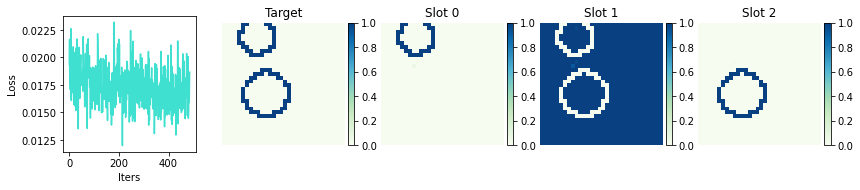

iter 490 , loss 0.017801218 , lr 2.6767553265644287e-05


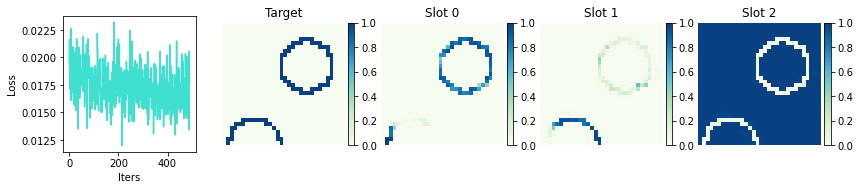

iter 495 , loss 0.014813792 , lr 2.7038817311318905e-05


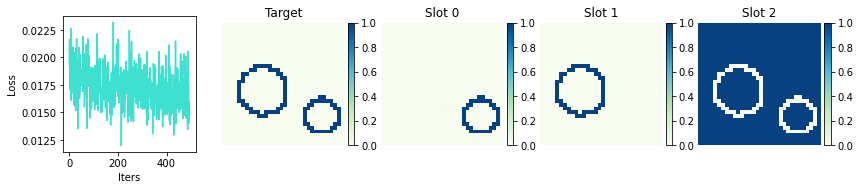

iter 500 , loss 0.016542919 , lr 2.7310043624518492e-05


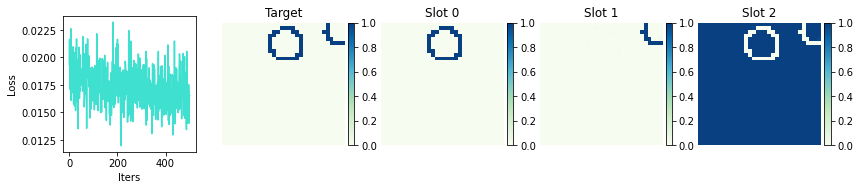

iter 505 , loss 0.0156109 , lr 2.7581232209170497e-05


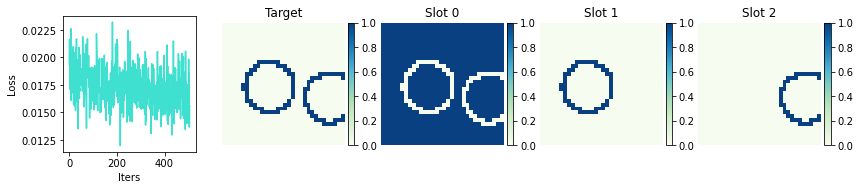

iter 510 , loss 0.017980766 , lr 2.7852383069202004e-05


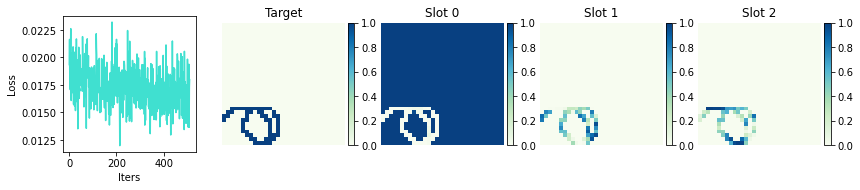

iter 515 , loss 0.016031854 , lr 2.8123496208539727e-05


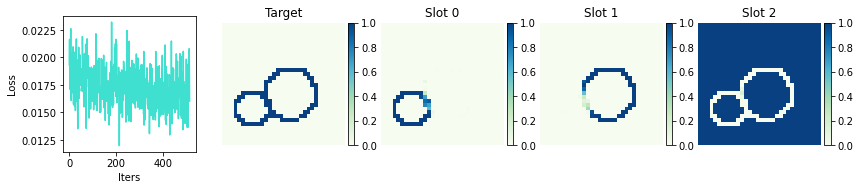

iter 520 , loss 0.018977081 , lr 2.839457163111003e-05


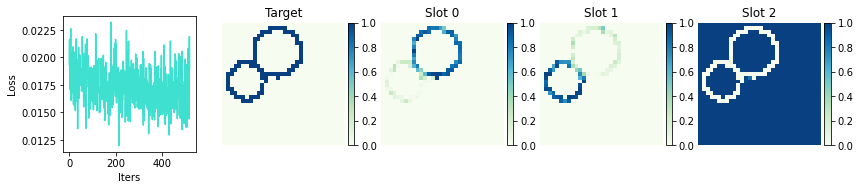

iter 525 , loss 0.015871659 , lr 2.8665609340838892e-05


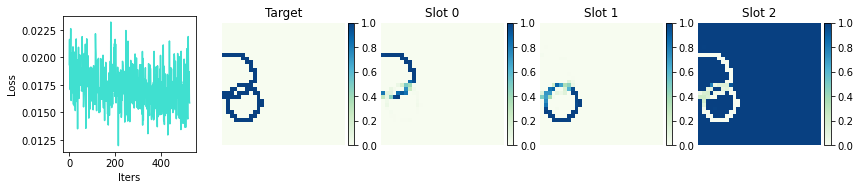

iter 530 , loss 0.018431645 , lr 2.8936609341651957e-05


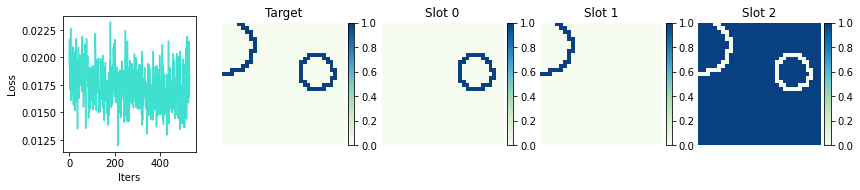

iter 535 , loss 0.0165545 , lr 2.9207571637474477e-05


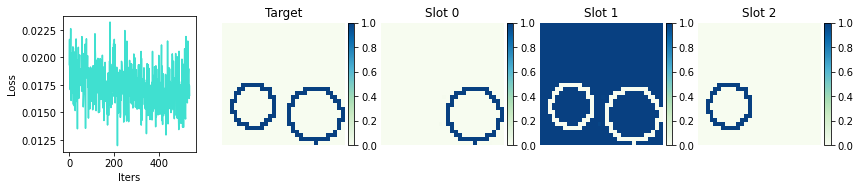

iter 540 , loss 0.017534634 , lr 2.947849623223136e-05


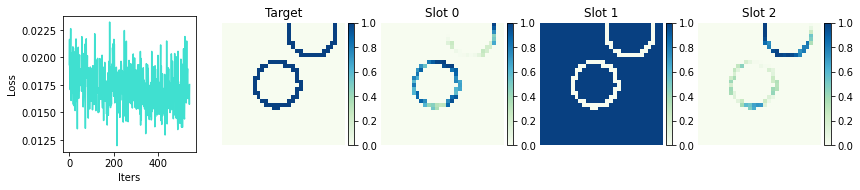

iter 545 , loss 0.018466821 , lr 2.974938312984715e-05


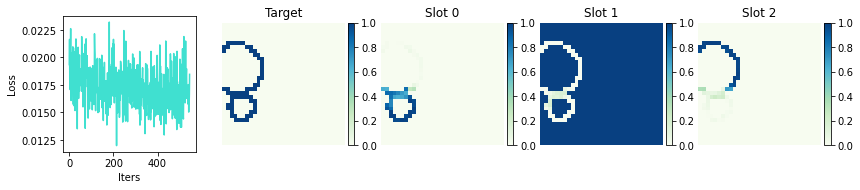

iter 550 , loss 0.0162146 , lr 3.0020232334246013e-05


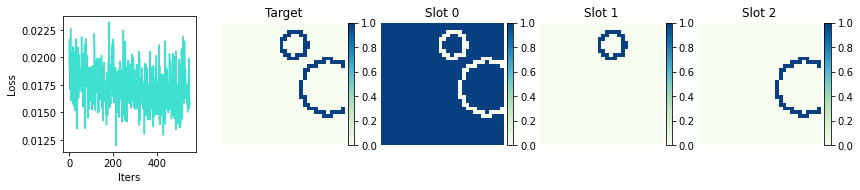

iter 555 , loss 0.017057309 , lr 3.0291043849351777e-05


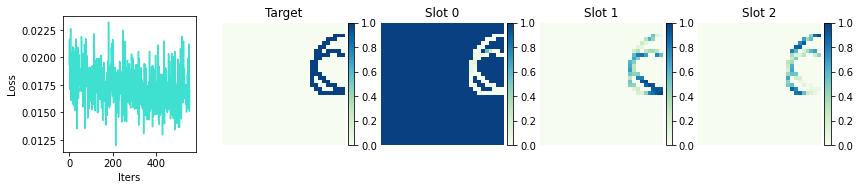

iter 560 , loss 0.018386535 , lr 3.0561817679087885e-05


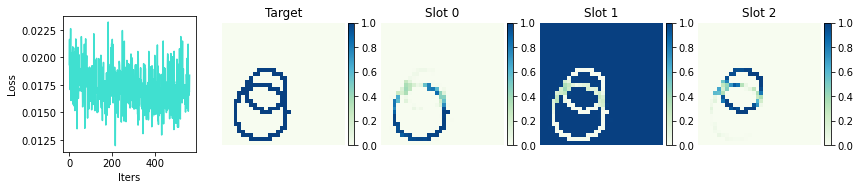

iter 565 , loss 0.015552351 , lr 3.083255382737743e-05


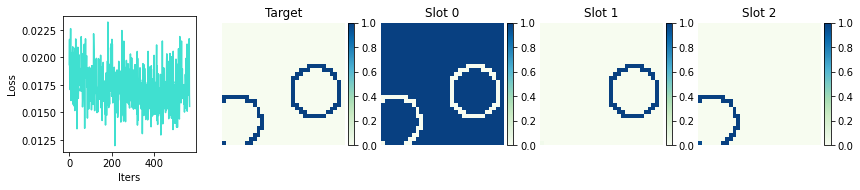

iter 570 , loss 0.016709525 , lr 3.1103252298143135e-05


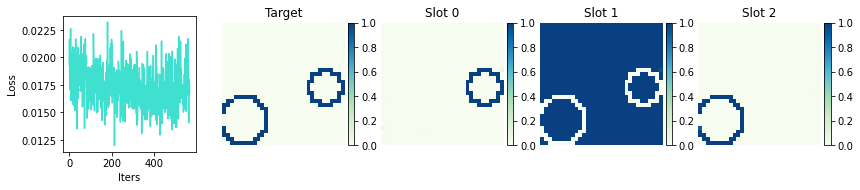

iter 575 , loss 0.014287052 , lr 3.1373913095307365e-05


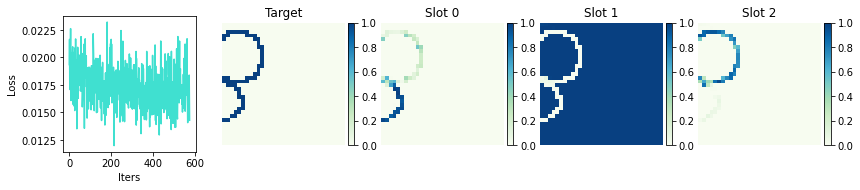

iter 580 , loss 0.018688956 , lr 3.164453622279212e-05


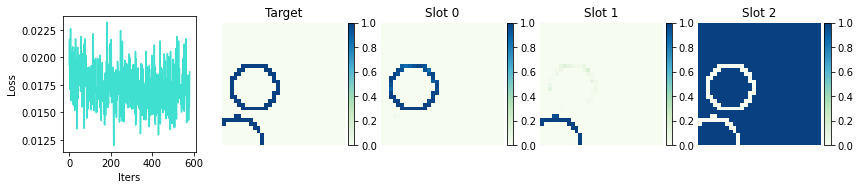

iter 585 , loss 0.016621854 , lr 3.191512168451903e-05


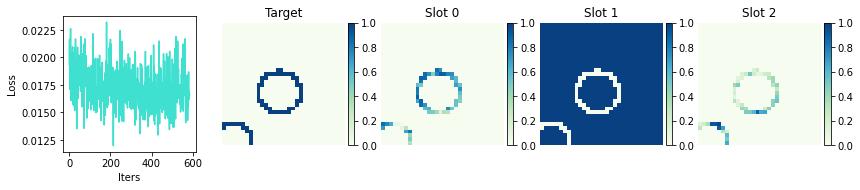

iter 590 , loss 0.015069685 , lr 3.218566948440938e-05


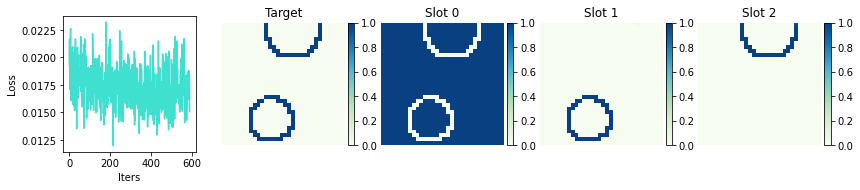

iter 595 , loss 0.016473286 , lr 3.2456179626384075e-05


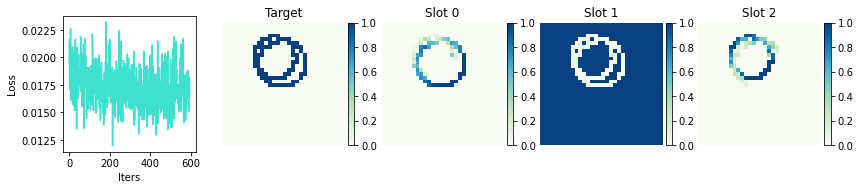

iter 600 , loss 0.01853358 , lr 3.272665211436367e-05


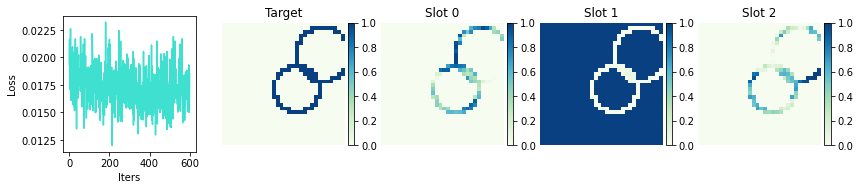

iter 605 , loss 0.018383984 , lr 3.299708695226836e-05


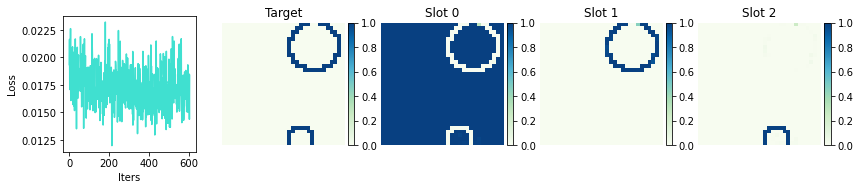

iter 610 , loss 0.016242046 , lr 3.326748414401796e-05


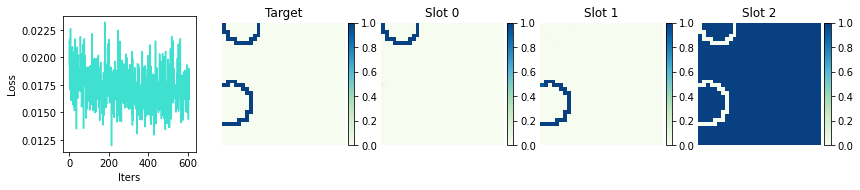

iter 615 , loss 0.02039484 , lr 3.353784369353192e-05


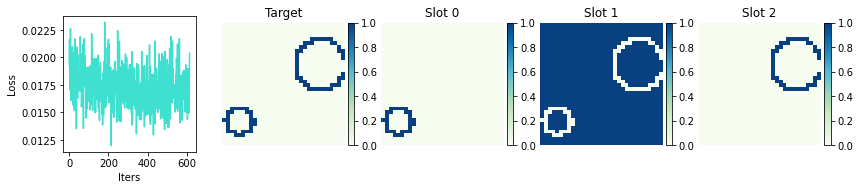

iter 620 , loss 0.016163686 , lr 3.380816560472936e-05


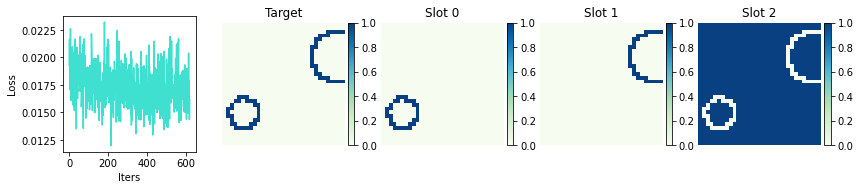

iter 625 , loss 0.017632004 , lr 3.407844988152901e-05


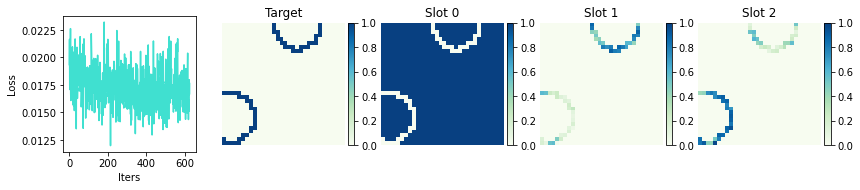

iter 630 , loss 0.013147689 , lr 3.434869652784925e-05


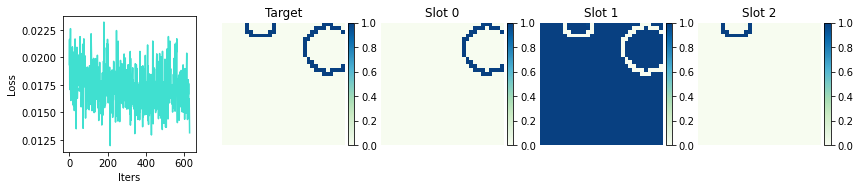

iter 635 , loss 0.015055053 , lr 3.461890554760807e-05


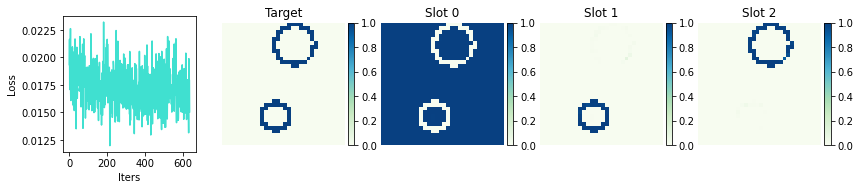

iter 640 , loss 0.013964433 , lr 3.488907694472315e-05


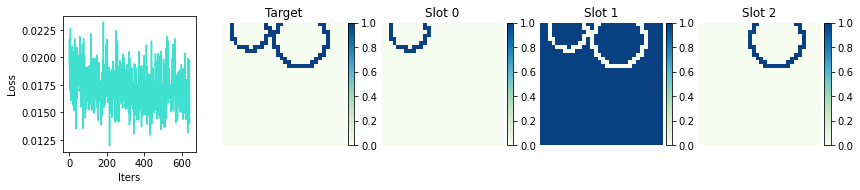

iter 645 , loss 0.014824658 , lr 3.5159210723111764e-05


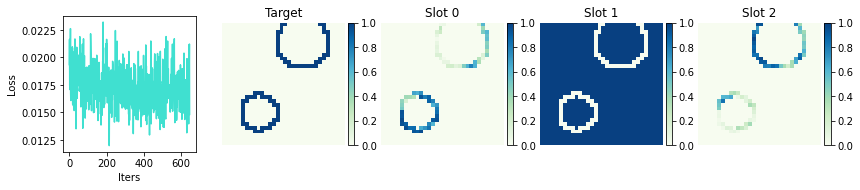

iter 650 , loss 0.015602302 , lr 3.542930688669083e-05


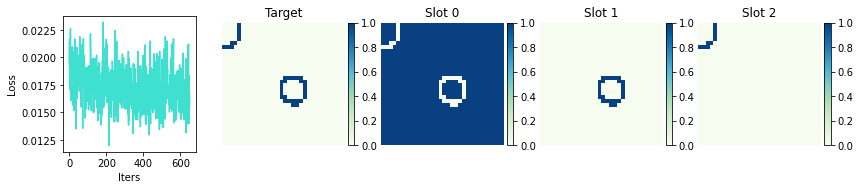

iter 655 , loss 0.015337455 , lr 3.5699365439376925e-05


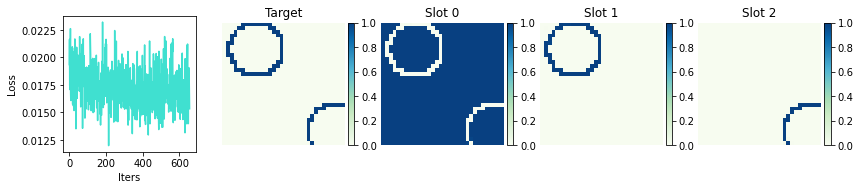

iter 660 , loss 0.018378923 , lr 3.5969386385086247e-05


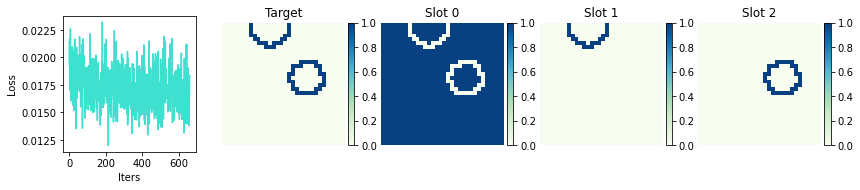

iter 665 , loss 0.015494795 , lr 3.6239369727734624e-05


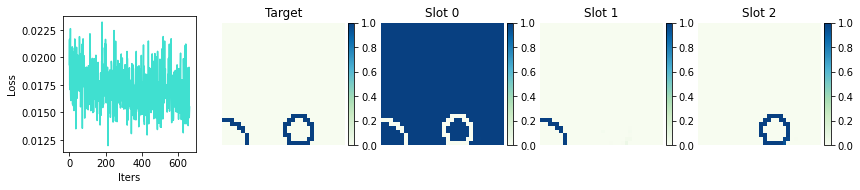

iter 670 , loss 0.019368637 , lr 3.6509315471237545e-05


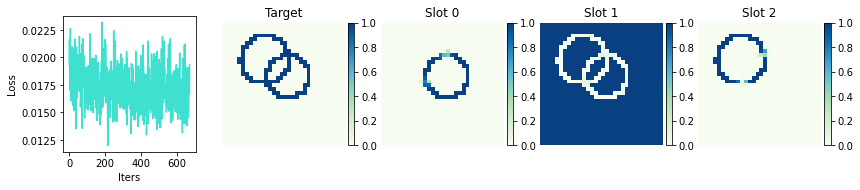

iter 675 , loss 0.017877458 , lr 3.677922361951012e-05


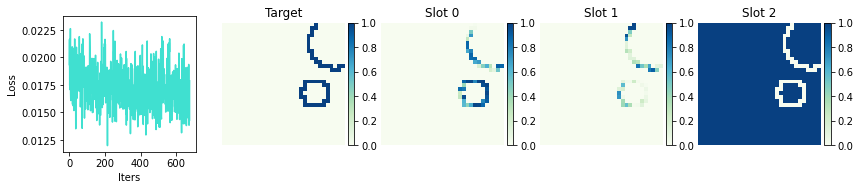

iter 680 , loss 0.016264947 , lr 3.70490941764671e-05


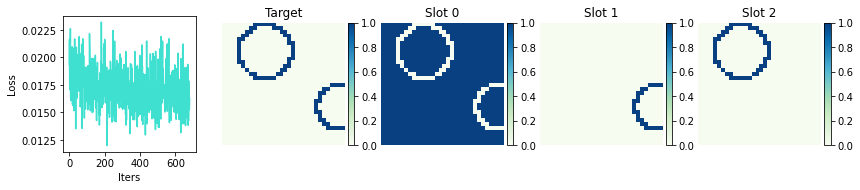

iter 685 , loss 0.01690058 , lr 3.7318927146022876e-05


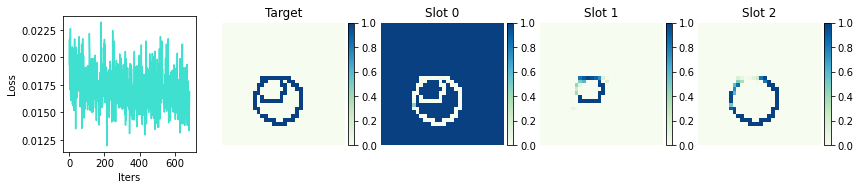

iter 690 , loss 0.021006078 , lr 3.758872253209147e-05


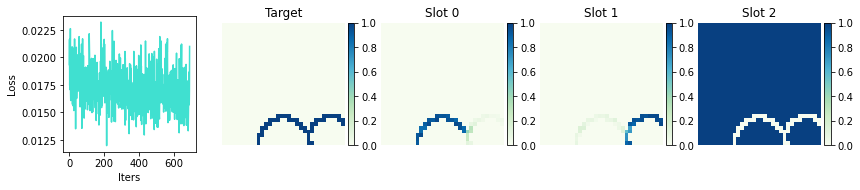

iter 695 , loss 0.01716765 , lr 3.785848033858657e-05


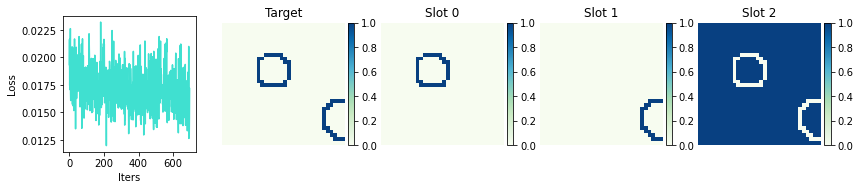

iter 700 , loss 0.015013443 , lr 3.8128200569421455e-05


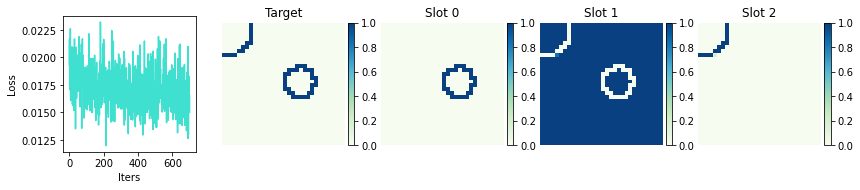

iter 705 , loss 0.018124754 , lr 3.839788322850907e-05


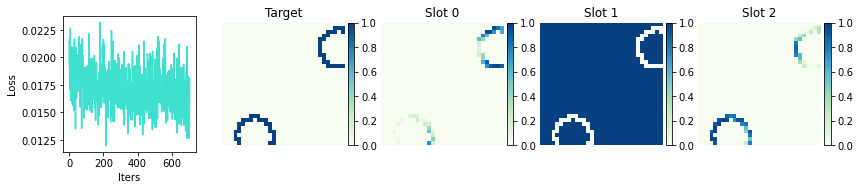

iter 710 , loss 0.018992964 , lr 3.8667528319762024e-05


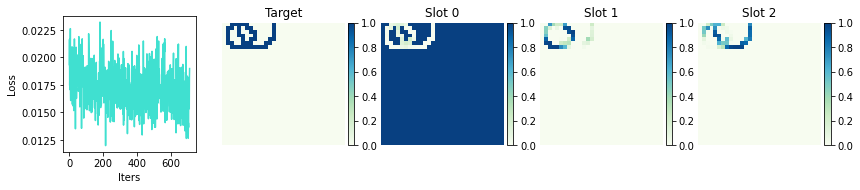

iter 715 , loss 0.017131837 , lr 3.8937135847092496e-05


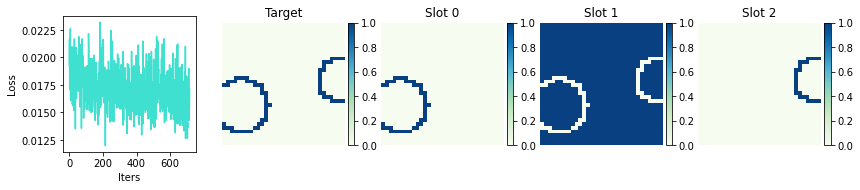

iter 720 , loss 0.014469164 , lr 3.920670581441237e-05


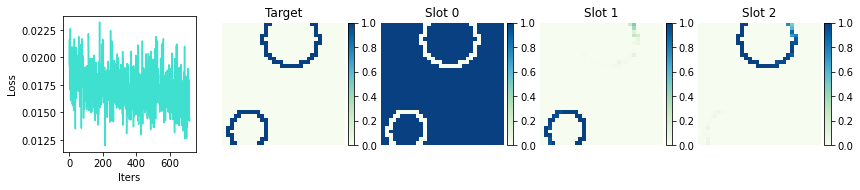

iter 725 , loss 0.017600287 , lr 3.9476238225633135e-05


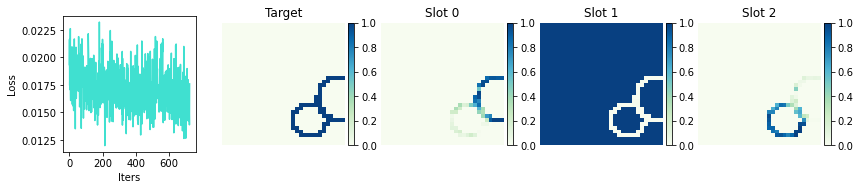

iter 730 , loss 0.015802396 , lr 3.974573308466593e-05


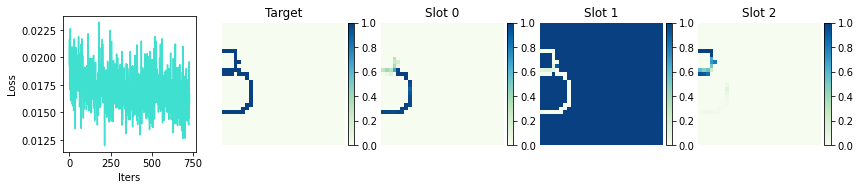

iter 735 , loss 0.016437897 , lr 4.0015190395421504e-05


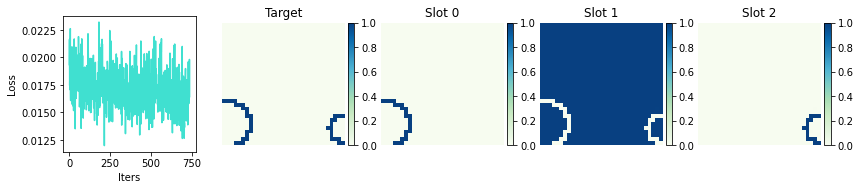

iter 740 , loss 0.015323581 , lr 4.028461016181029e-05


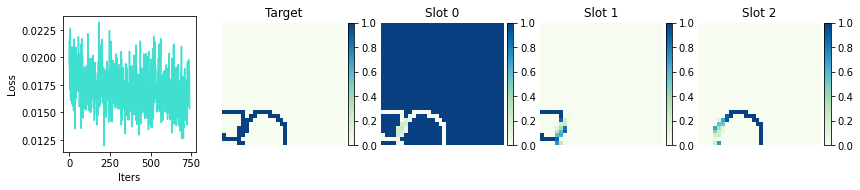

iter 745 , loss 0.016933784 , lr 4.055399238774232e-05


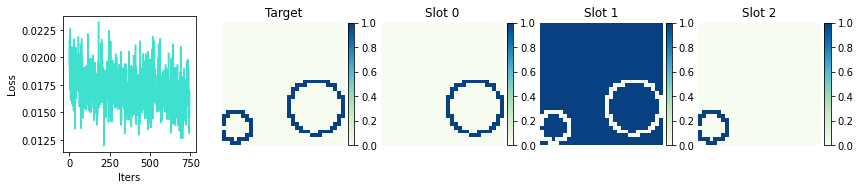

iter 750 , loss 0.019494513 , lr 4.0823337077127283e-05


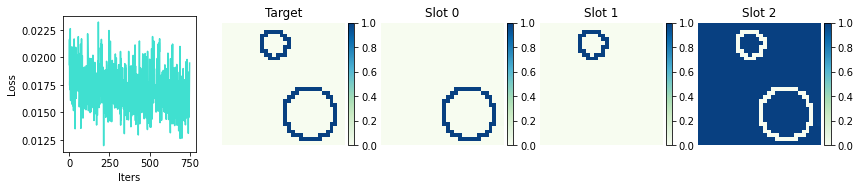

iter 755 , loss 0.016352996 , lr 4.109264423387451e-05


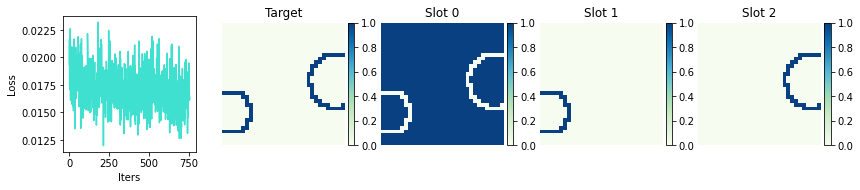

iter 760 , loss 0.016383866 , lr 4.136191386189297e-05


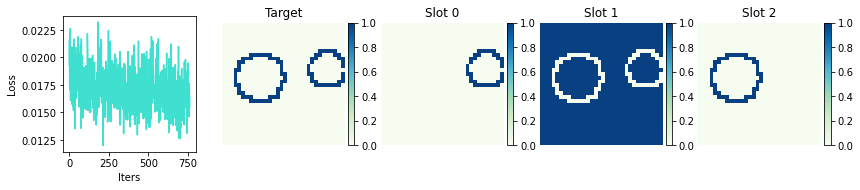

iter 765 , loss 0.016172685 , lr 4.163114596509126e-05


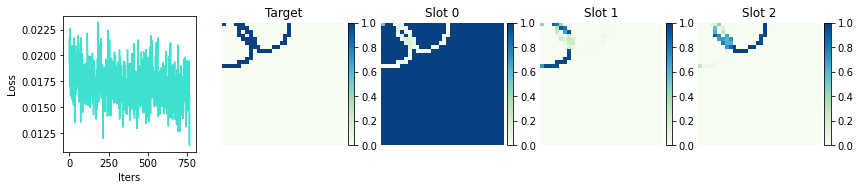

iter 770 , loss 0.0175996 , lr 4.1900340547377606e-05


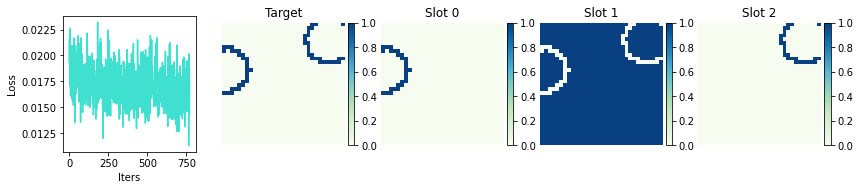

iter 775 , loss 0.016728645 , lr 4.21694976126599e-05


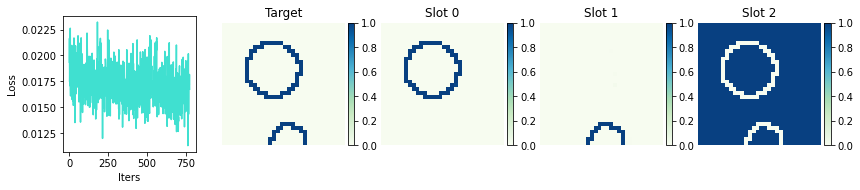

iter 780 , loss 0.013789082 , lr 4.243861716484565e-05


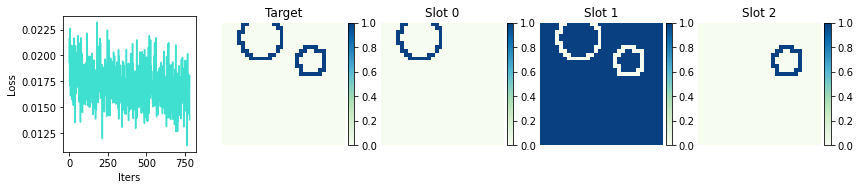

iter 785 , loss 0.01746175 , lr 4.2707699207842026e-05


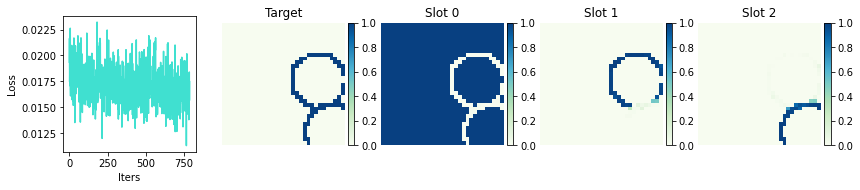

iter 790 , loss 0.015073939 , lr 4.2976743745555814e-05


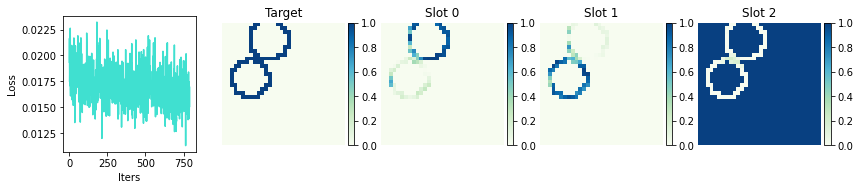

iter 795 , loss 0.01599485 , lr 4.3245750781893446e-05


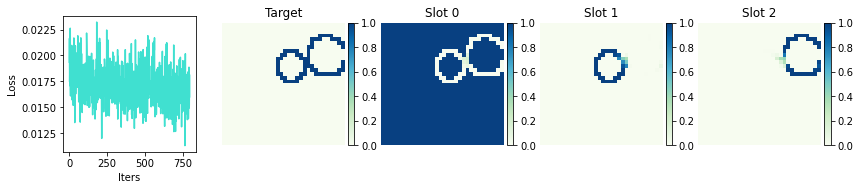

iter 800 , loss 0.017032735 , lr 4.351472032076099e-05


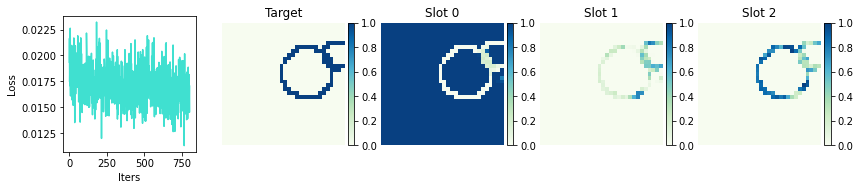

iter 805 , loss 0.017409828 , lr 4.378365236606416e-05


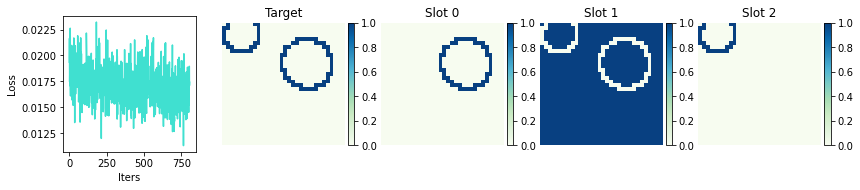

iter 810 , loss 0.015636027 , lr 4.405254692170831e-05


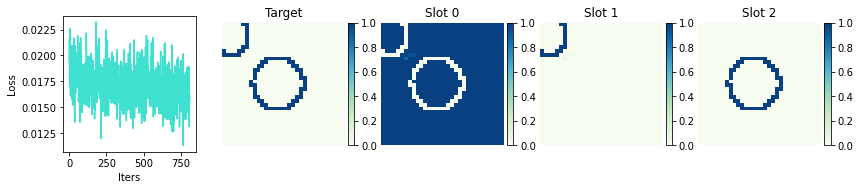

iter 815 , loss 0.016432816 , lr 4.432140399159842e-05


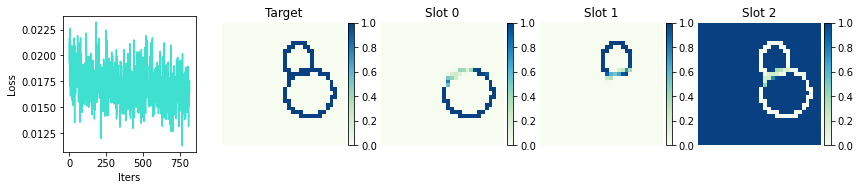

iter 820 , loss 0.016423114 , lr 4.459022357963912e-05


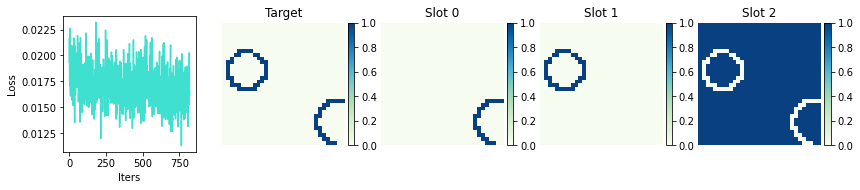

iter 825 , loss 0.014997607 , lr 4.485900568973467e-05


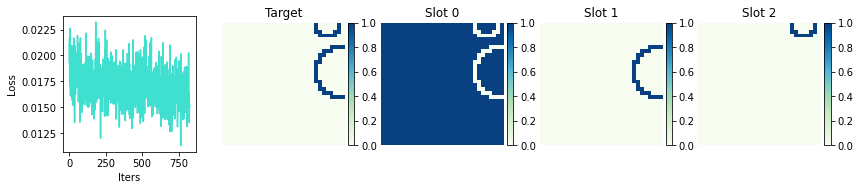

iter 830 , loss 0.01673431 , lr 4.5127750325788985e-05


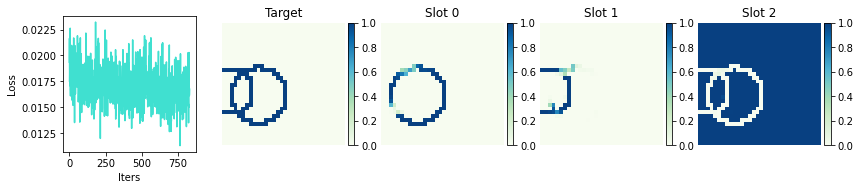

iter 835 , loss 0.01787551 , lr 4.5396457491705594e-05


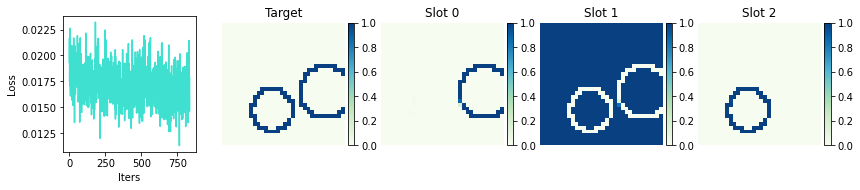

iter 840 , loss 0.014740074 , lr 4.566512719138769e-05


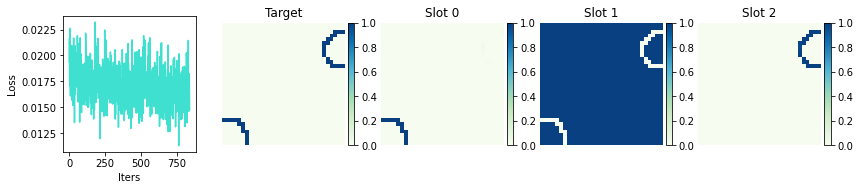

iter 845 , loss 0.016457487 , lr 4.593375942873809e-05


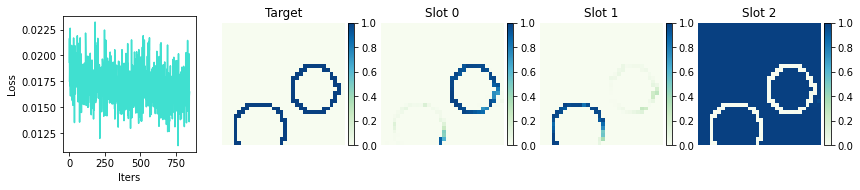

iter 850 , loss 0.015646702 , lr 4.620235420765926e-05


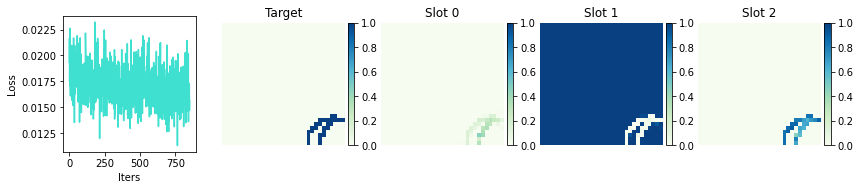

iter 855 , loss 0.015734658 , lr 4.647091153205328e-05


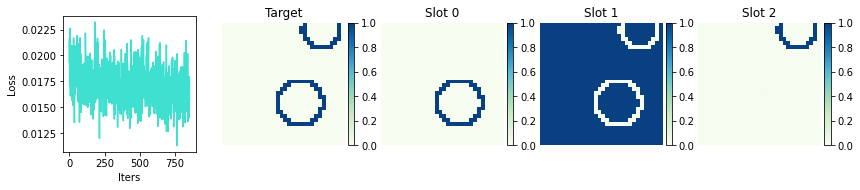

iter 860 , loss 0.017484792 , lr 4.6739431405821894e-05


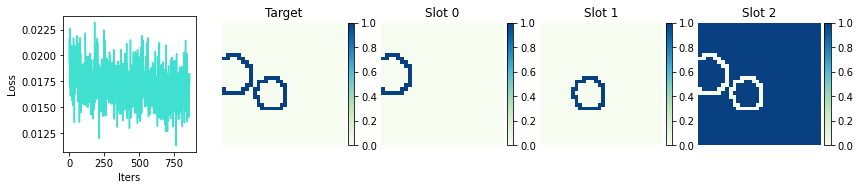

iter 865 , loss 0.020350073 , lr 4.7007913832866494e-05


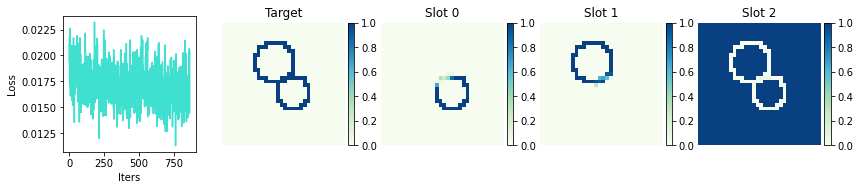

iter 870 , loss 0.015445084 , lr 4.7276358817088095e-05


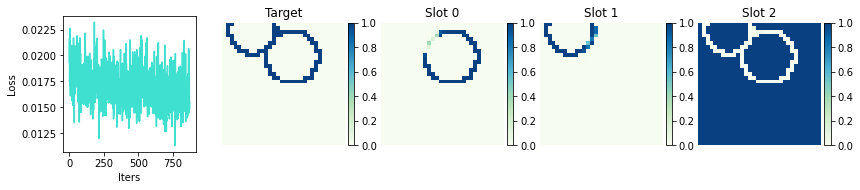

iter 875 , loss 0.01501161 , lr 4.754476636238734e-05


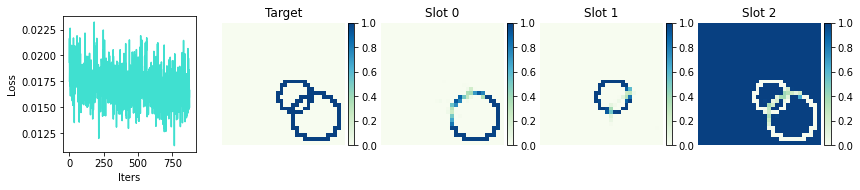

iter 880 , loss 0.015900422 , lr 4.781313647266452e-05


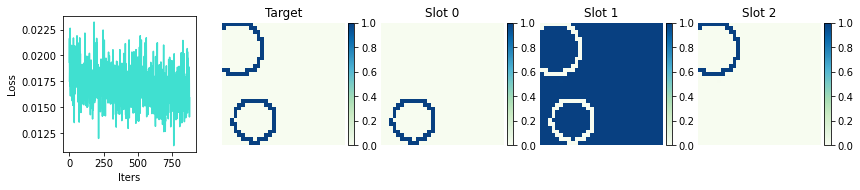

iter 885 , loss 0.01763235 , lr 4.808146915181958e-05


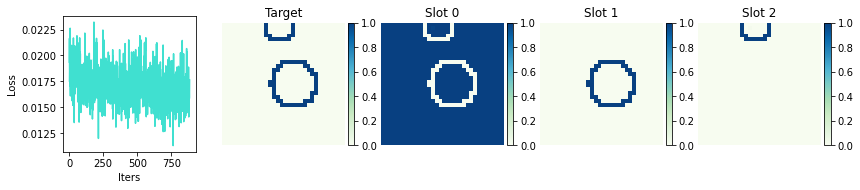

iter 890 , loss 0.017111644 , lr 4.834976440375209e-05


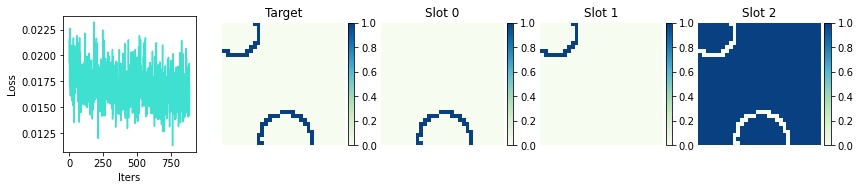

iter 895 , loss 0.018718313 , lr 4.8618022232361264e-05


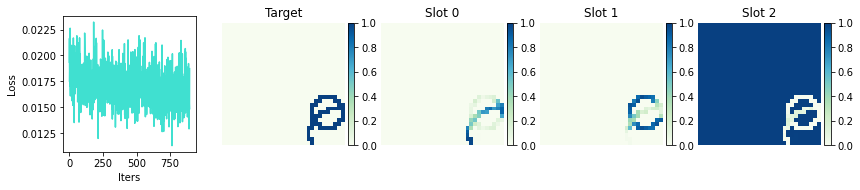

iter 900 , loss 0.01630329 , lr 4.8886242641545934e-05


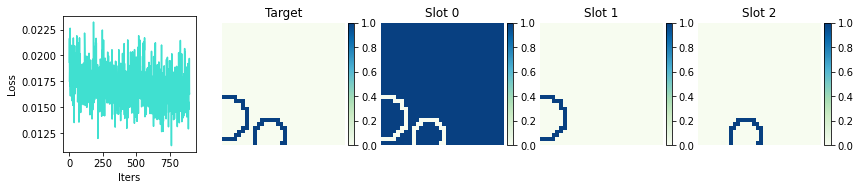

iter 905 , loss 0.017507846 , lr 4.915442563520462e-05


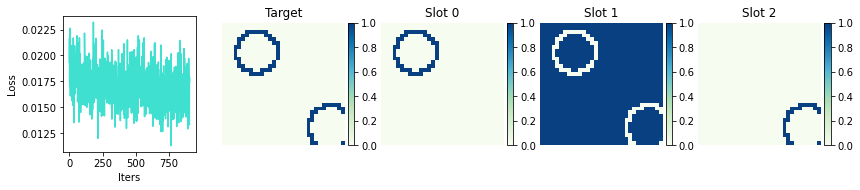

iter 910 , loss 0.015198714 , lr 4.9422571217235434e-05


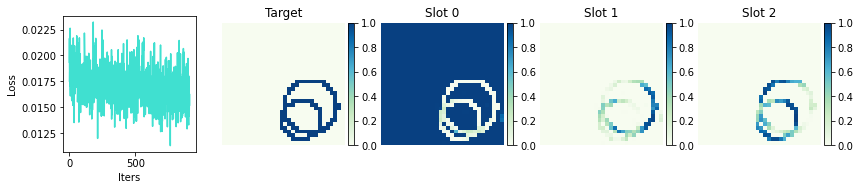

iter 915 , loss 0.018588856 , lr 4.9690679391536146e-05


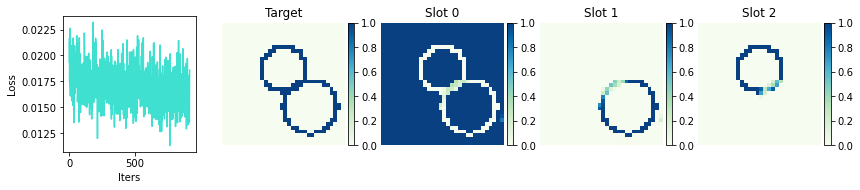

iter 920 , loss 0.015420424 , lr 4.995875016200417e-05


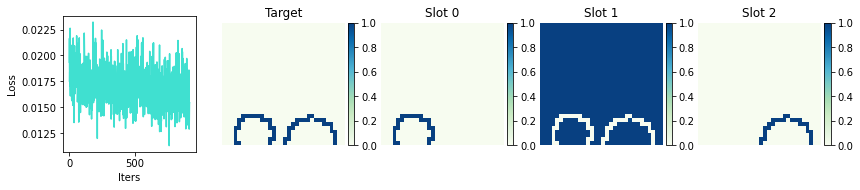

iter 925 , loss 0.013555616 , lr 5.022678353253655e-05


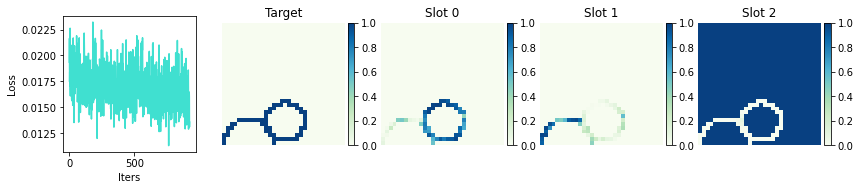

iter 930 , loss 0.017806673 , lr 5.0494779507029964e-05


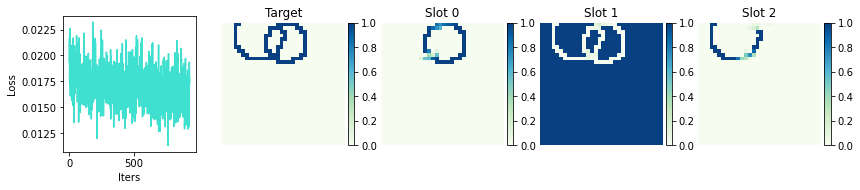

iter 935 , loss 0.015289182 , lr 5.0762738089380765e-05


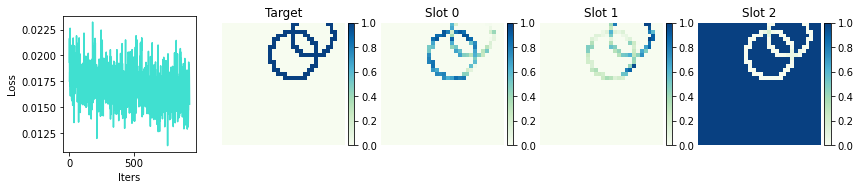

iter 940 , loss 0.015980255 , lr 5.103065928348489e-05


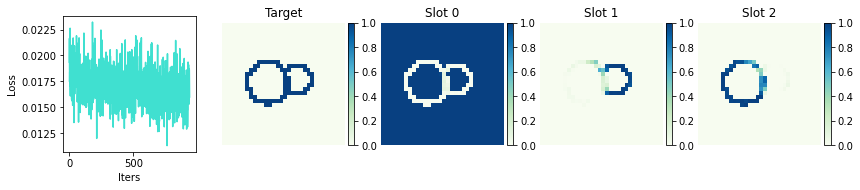

iter 945 , loss 0.014911206 , lr 5.129854309323797e-05


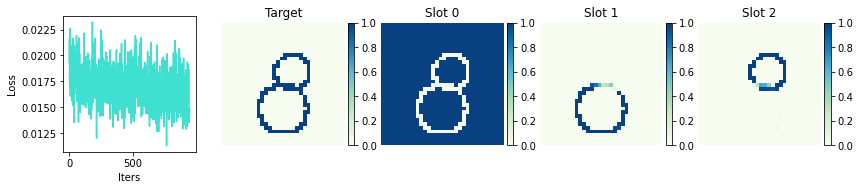

iter 950 , loss 0.015540969 , lr 5.1566389522535247e-05


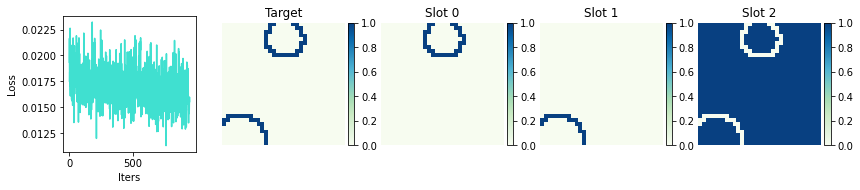

iter 955 , loss 0.014824537 , lr 5.183419857527158e-05


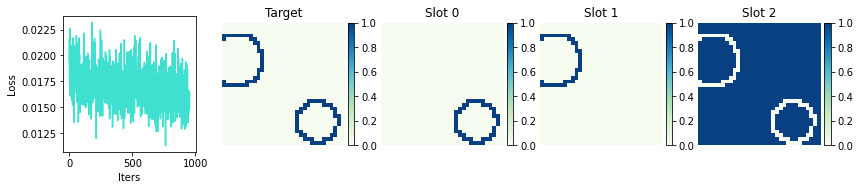

iter 960 , loss 0.016400408 , lr 5.210197025534152e-05


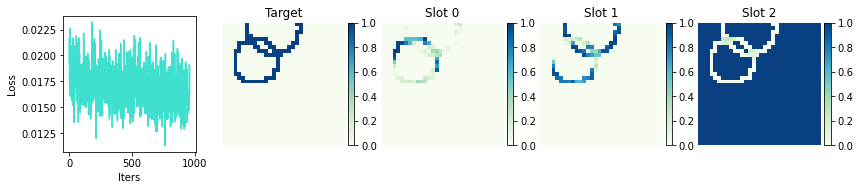

iter 965 , loss 0.016578186 , lr 5.236970456663923e-05


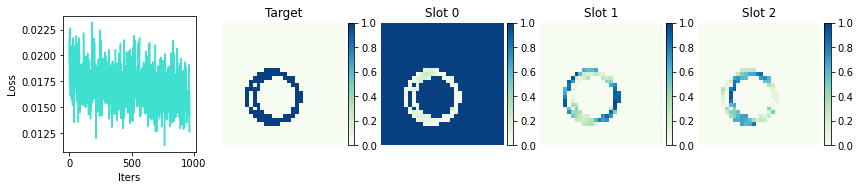

iter 970 , loss 0.015591701 , lr 5.26374015130585e-05


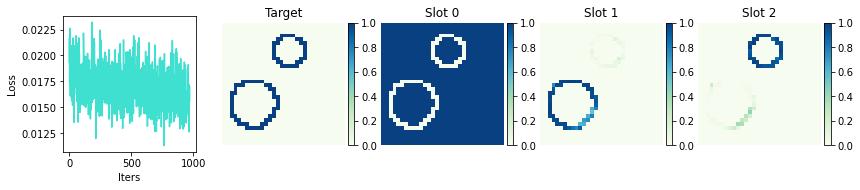

iter 975 , loss 0.013785083 , lr 5.29050610984928e-05


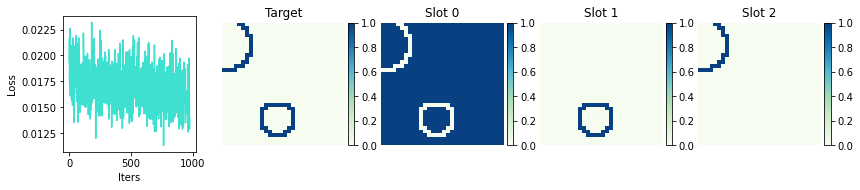

iter 980 , loss 0.019270606 , lr 5.317268332683518e-05


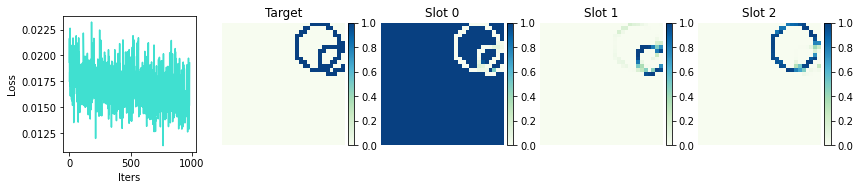

iter 985 , loss 0.019246604 , lr 5.3440268201978384e-05


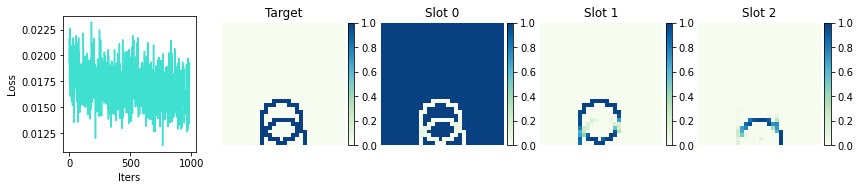

iter 990 , loss 0.01827778 , lr 5.3707815727814776e-05


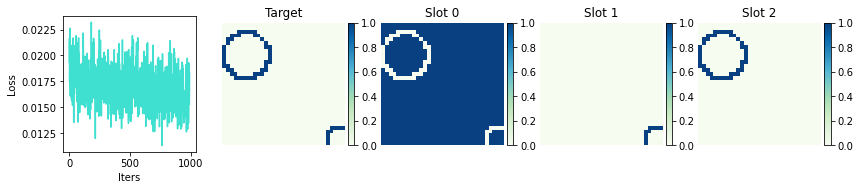

iter 995 , loss 0.01643152 , lr 5.3975325908236356e-05


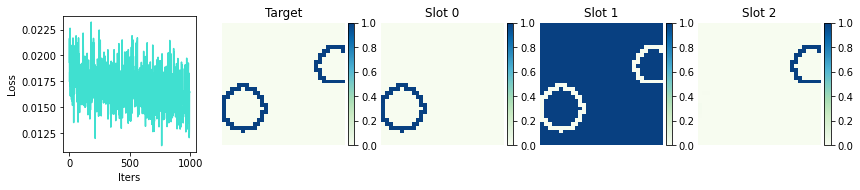

iter 1000 , loss 0.01820971 , lr 5.424279874713476e-05


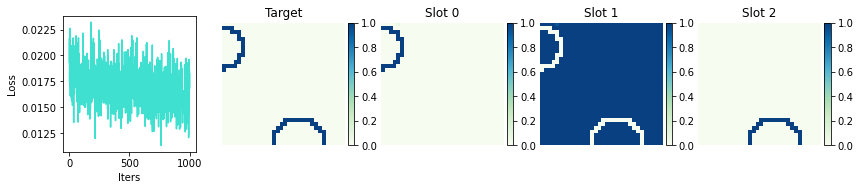

iter 1005 , loss 0.014961712 , lr 5.451023424840128e-05


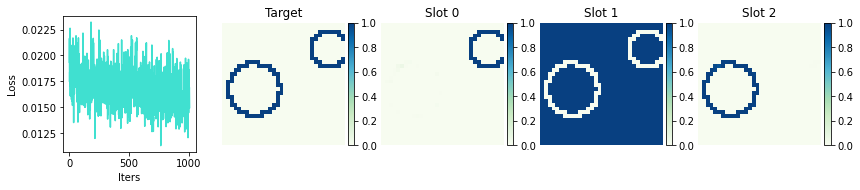

iter 1010 , loss 0.015295052 , lr 5.4777632415926845e-05


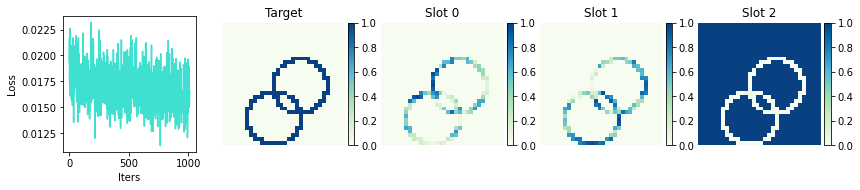

iter 1015 , loss 0.015985506 , lr 5.504499325360201e-05


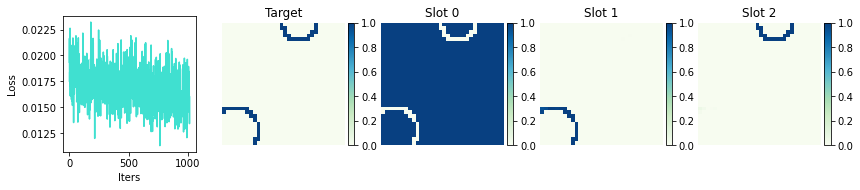

iter 1020 , loss 0.01885492 , lr 5.531231676531696e-05


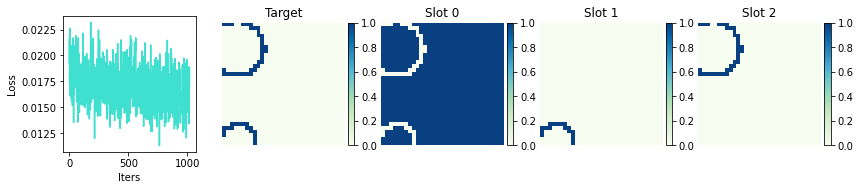

iter 1025 , loss 0.016085956 , lr 5.557960295496157e-05


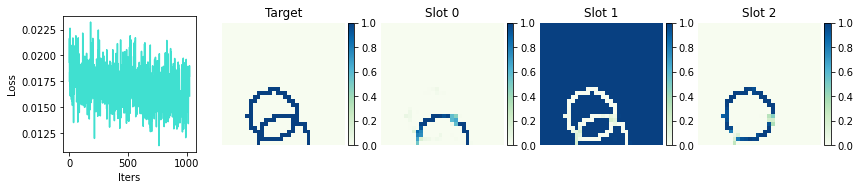

iter 1030 , loss 0.017839082 , lr 5.5846851826425315e-05


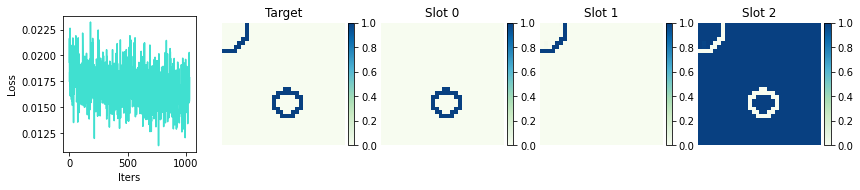

iter 1035 , loss 0.014379243 , lr 5.611406338359731e-05
iter 1155 , loss 0.014410021 , lr 6.251595657360988e-05


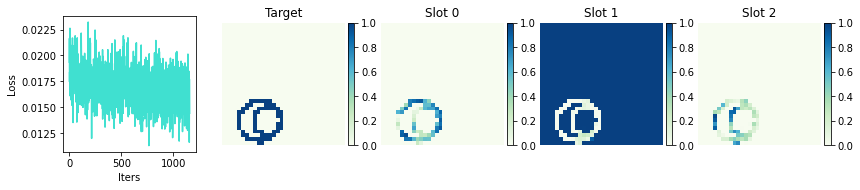

iter 1160 , loss 0.013599849 , lr 6.27822365364014e-05


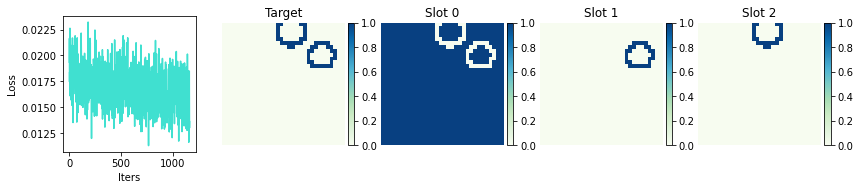

iter 1165 , loss 0.014984138 , lr 6.304847928589215e-05


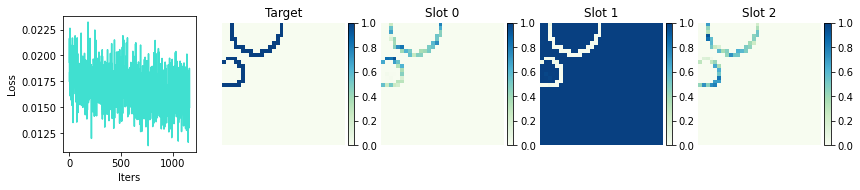

iter 1170 , loss 0.017413657 , lr 6.331468482596156e-05


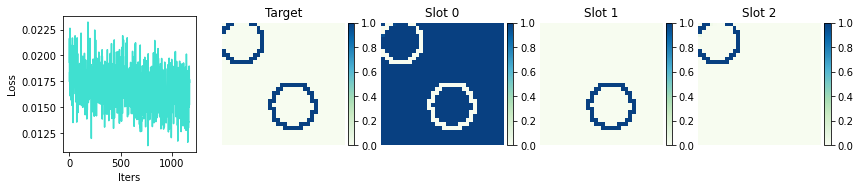

iter 1175 , loss 0.01757002 , lr 6.358085316048872e-05


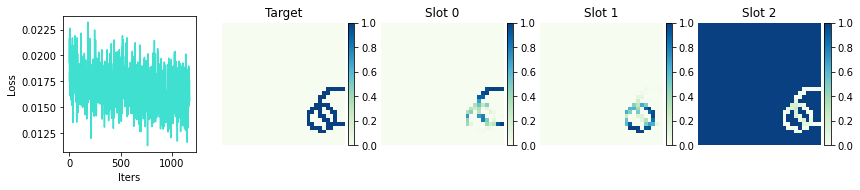

iter 1180 , loss 0.013687186 , lr 6.384698429335231e-05


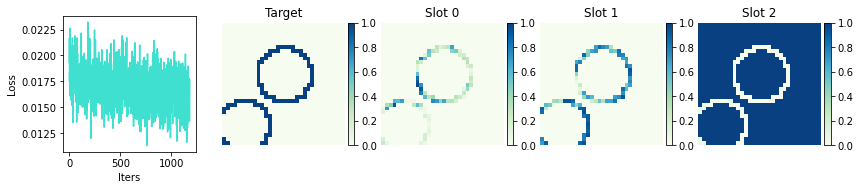

iter 1185 , loss 0.014785937 , lr 6.411307822843067e-05


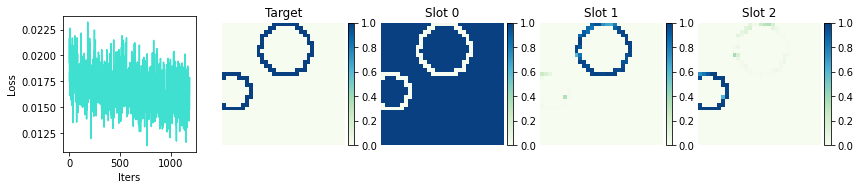

iter 1190 , loss 0.012590541 , lr 6.437913496960177e-05


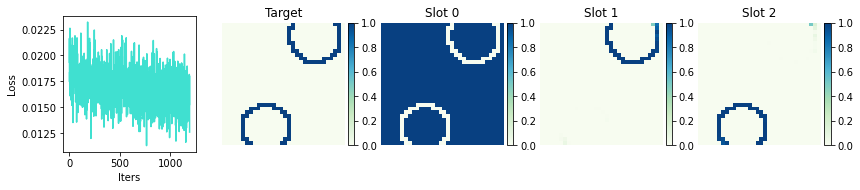

iter 1195 , loss 0.013868125 , lr 6.464515452074326e-05


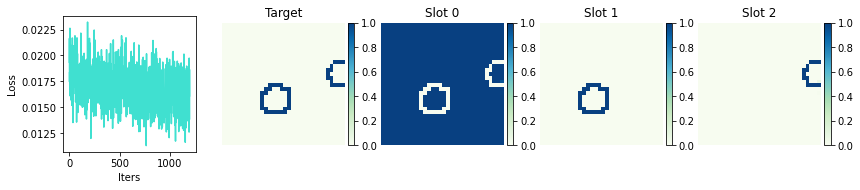

iter 1200 , loss 0.019224145 , lr 6.491113688573239e-05


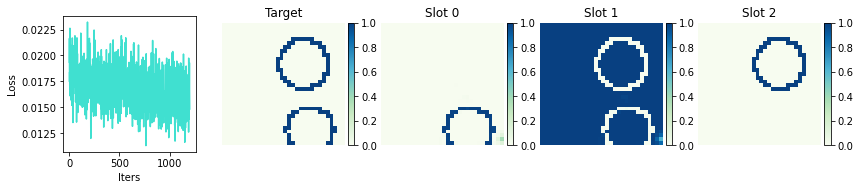

iter 1205 , loss 0.017201714 , lr 6.517708206844608e-05


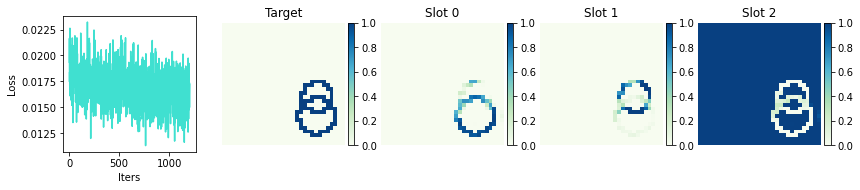

iter 1210 , loss 0.016302485 , lr 6.544299007276086e-05


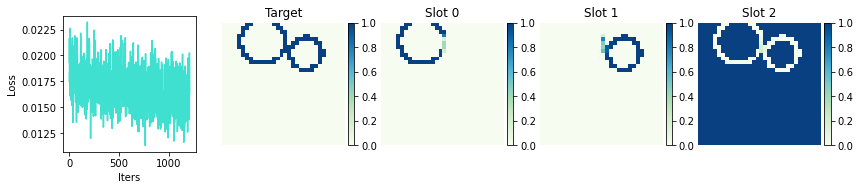

iter 1215 , loss 0.015975956 , lr 6.570886090255294e-05


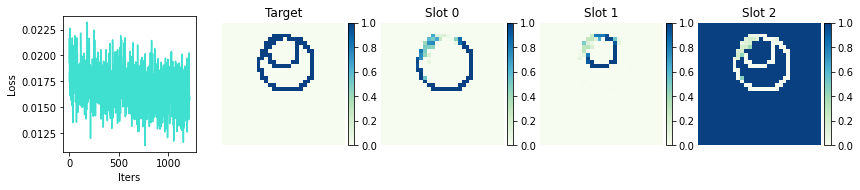

iter 1220 , loss 0.015631236 , lr 6.597469456169813e-05


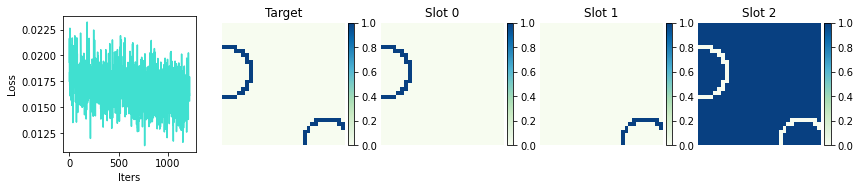

iter 1225 , loss 0.015495932 , lr 6.62404910540719e-05


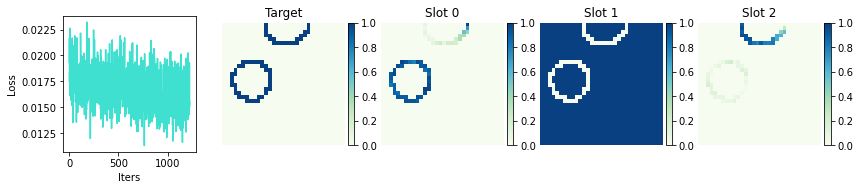

iter 1230 , loss 0.018386323 , lr 6.650625038354937e-05


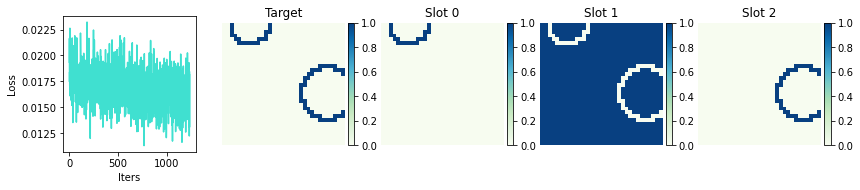

iter 1235 , loss 0.015349297 , lr 6.677197255400532e-05


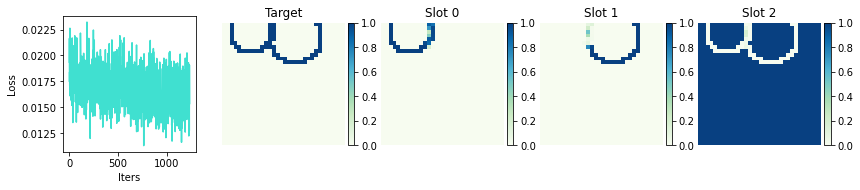

iter 1240 , loss 0.015244881 , lr 6.70376575693141e-05


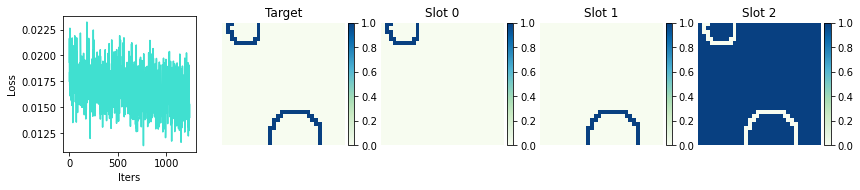

iter 1245 , loss 0.0155308135 , lr 6.730330543334977e-05


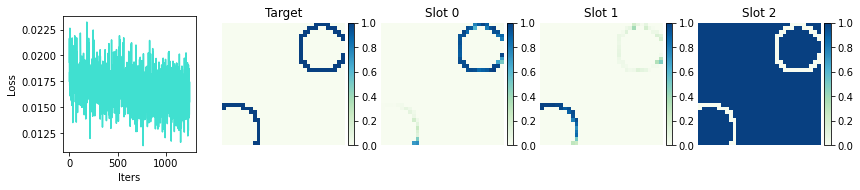

iter 1250 , loss 0.018077876 , lr 6.756891614998601e-05


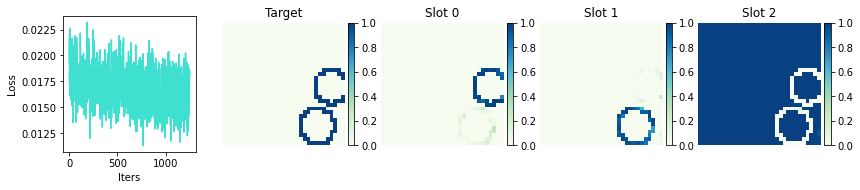

In [ ]:
%%time
train(m,kwargs=kwargs,**opt,color='turquoise',cmap='GnBu',device=device,
      modelDir=modelDir,figDir=figDir,plot_every=5,save_every=200)

In [24]:
with open(f'code/models/{cID}/loss.json') as f:
    ld = json.load(f)

(0.0, 0.1)

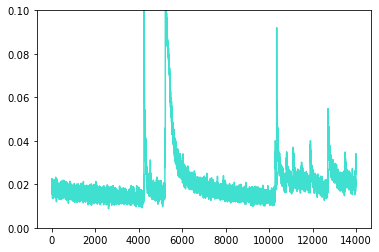

In [26]:
plt.plot(ld,color='turquoise')
plt.ylim(0,.1)

In [27]:
cID

'li-warm-parallel-10x'

In [28]:
cID2='li-warm-restart-10x'
with open(f'code/models/{cID2}/loss.json') as f:
    ld2 = json.load(f)

(0.0, 0.1)

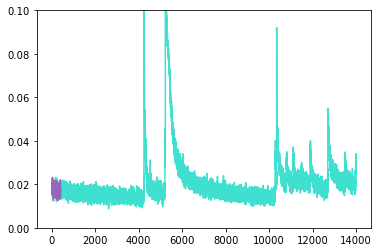

In [30]:
plt.plot(ld,color='turquoise')
plt.plot(ld2,color='C4')
plt.ylim(0,.1)